In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from scipy.stats import gaussian_kde

from  datetime import date
#import statsmodels.api as sm
import pylab 
import scipy.stats as stats
today=date.today()
import math
today=(today.strftime('%Y-%m-%d'))

In [16]:
#Semilla aleatoria de numpy
np.random.seed(0)
nivelsignificatividad=0.05

#Paremtros adicionales
#Numero de días para tener en cuenta en la predicción
back=40
#Porcentaje de entrenamiento
train=0.8

In [17]:
#Librerias necesarias para las redes neuronales
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,LSTM, Input, Activation, concatenate

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History

#Semilla aleatoria de tsnsorflow
tf.random.set_seed(0)


In [18]:
#Funcion de resumen para el rendimiento de cada red neuronal
#Se le pasa por parametro la configuracion de la red, predicción y datos reales.Devuelve un dataframe con el calculo de estadisticos y normalidad del residuo
#Se guarda ademas para cada red el numero de epochs para el que ha minimizado al perdida porque habrá que volver a usar esta parámetro para predicción
def resumen(nummodelo,back,numregressors,epochs,neuronashidden1,neuronashidden2,neuronashidden3,y_test,y_pred,LSTM=True):
    
    n=y_pred.shape[0]
    k=numregressors
    res=(y_pred-y_test)
    #res = res[~np.isnan(res)]
    sumares=np.sum(res)
    
    res2=(y_pred-y_test)**2
    sumres2=np.sum(res2,axis=0)
    #y_pred=y_predic
    
           
#Media residuo
    mediares=res.mean()
#Desv resudio
    desvres=res.std()
#RMSE
    rmse=np.sqrt((sumres2/n))
#MEA
    mae=(1/n)*np.sum(np.abs(res))
#MAPE
    mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))

#AKAIKE
    L=(-n/2)*(1+math.log(2*math.pi)-math.log(n))-((n/2)*math.log(sumres2))
    AIC=n*(math.log(sumres2/n))+(2*k)+(n*(1+math.log(2*math.pi)))

#Davidson and MCKInnon
    DM=L-k
#BIC(Bayesian Information Criterio)
    BIC=(-2*L)+(k*math.log(n))

#Hannan and Quinn
    HQC=(-2*L)+(2*k*math.log(math.log(n)))

#bias
    bias=(1/n)*np.sum(res)
#Jarque-Bera normalidad residuo
    pvalue=stats.jarque_bera(res)[1]
###Gráfica
  

    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'black', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.legend()
    plt.show()
    
     

###Comparativa
    datoscomparativa= [{'NumModelo':nummodelo,'Dias Muestra':back,'LSTM':LSTM,'Regresores':numregressors,'Epochs':epochs,'Capa Oculta1': neuronashidden1, 'Capao Oculta2': neuronashidden2, 'CapaOculta3': neuronashidden3,'Bias':bias,'Residuo':sumares,'Media Residuo':res.mean(),'Residuo **2':round(sumres2[0],10),'P-value Jarque Bera':pvalue,'RMSE':rmse[0],'MAE':mae,'MAPE':mape,'AKAIKE':AIC,'BIC':BIC,'HQC':HQC,'DM':DM}]
    dfcomparativa=pd.DataFrame(datoscomparativa)

    return dfcomparativa

In [19]:
#Primeros modelos sin añadir regresores

In [20]:
#Descarga de datos
data = yf.download(tickers = 'REP.MC', start = '1987-06-12',end = today)

data.reset_index(inplace = True)
#Elimino fecha y cierre ajustado por ser igual en muchos casos al precio de cierre que se pretende predecir
data.drop(['Date','Adj Close'],axis=1, inplace=True)
data.dropna(inplace=True)
#Obtener de manera automatica el nuḿero de variables a evaluar 
#Todos los valores excepto el precio de cierre que es lo que se pretende predecir
numregressors=data.shape[1]-1

#Por comodidad paso el precio de cierre o lo que quiero predecir  como última  columna

dataClose=data.loc[:, data.columns == 'Close']
data=data.loc[:, data.columns != 'Close']
data=pd.concat([data,dataClose],axis=1)


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:>

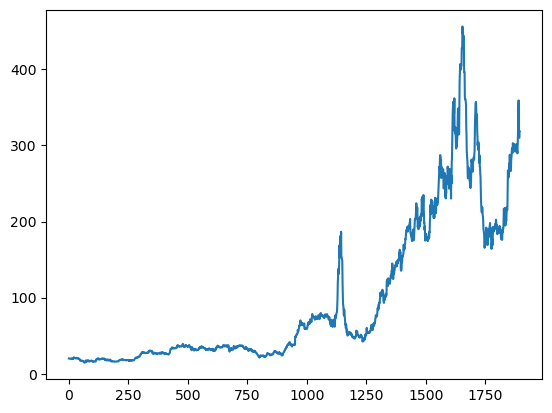

In [21]:
data['Close'].plot()

In [22]:
#debido al gran número de parámetros y la diferencia de magnitudes se estandarizan los datos para homegeneizar y obtener
#mejores resultados.
'''
La estandarización de los datos implica escalar los valores de entrada
para que tengan una media de cero y una desviación estándar de uno.
Esto ayuda a nivelar las diferencias en la escala y distribución de los datos,
lo que puede facilitar el proceso de aprendizaje de la red neuronal y mejorar su capacidad
para generalizar y hacer predicciones precisas en nuevos datos.
'''
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data)


In [23]:
'''
Va haciendo grupos de longitud backcandle.Por ejemplo si backcandle =10
esta vb es el numero de dias que cojo para una predicción

X seria
 0  1  2  3  4  5  6  7  8  9]
  [ 1  2  3  4  5  6  7  8  9 10]
  [ 2  3  4  5  6  7  8  9 10 11]
  [ 3  4  5  6  7  8  9 10 11 12]

j es el numero de columnas

i va desde del numero de backcandle hasta al total de registros

para y elimina tantos primeros registros como longitud del bacakcandle

[110]
 [111]
 [112]
 [113]
 [114]
 
Matrices  de ejemplo para probar el bucle

arr1=np.arange(100)
arr2=np.arange(100,200)
arr=np.c_[arr1,arr2]

En los nuevos shapes sale el total de la longitud menos backcandle

'''


X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


1896


In [24]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud
ndias=y_test.shape[0]

1484
(1484, 40, 4)
(372, 40, 4)
(1484, 1)
(372, 1)


In [25]:
#Creacion primera red neuronal Modelo1 de una sola capa oculta
neuronashidden1=150
neuronashidden2=0
neuronashidden3=0

In [26]:
# Entrada y salida
lstm_input = Input(shape=(back, numregressors), name='lstm_input')
inputs = LSTM(neuronashidden1, name='HiddenLayer1',return_sequences=True)(lstm_input)
output=LSTM(1,activation='linear',name ='Output_Layer')(inputs)
model1 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
HiddenLayer1 (LSTM)          (None, 40, 150)           93000     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 93,608
Trainable params: 93,608
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
model1.compile(optimizer=adam, loss='mse')
model1.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)


Epoch 1/30


2023-04-26 17:43:56.673151: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-26 17:43:56.686441: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-04-26 17:43:57.673678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-26 17:43:57.871280: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


89/89 [==============================] - 4s 22ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 2/30
89/89 [==============================] - 2s 18ms/step - loss: 1.6711e-04 - val_loss: 0.0018
Epoch 3/30
89/89 [==============================] - 2s 20ms/step - loss: 1.2582e-04 - val_loss: 0.0030
Epoch 4/30
89/89 [==============================] - 1s 16ms/step - loss: 1.0777e-04 - val_loss: 0.0033
Epoch 5/30
89/89 [==============================] - 1s 13ms/step - loss: 9.9106e-05 - val_loss: 0.0015
Epoch 6/30
89/89 [==============================] - 1s 15ms/step - loss: 7.9619e-05 - val_loss: 0.0030
Epoch 7/30
89/89 [==============================] - 2s 18ms/step - loss: 8.6216e-05 - val_loss: 0.0013
Epoch 8/30
89/89 [==============================] - 1s 14ms/step - loss: 9.1821e-05 - val_loss: 0.0032
Epoch 9/30
89/89 [==============================] - 1s 15ms/step - loss: 9.4311e-05 - val_loss: 6.3130e-04
Epoch 10/30
89/89 [==============================] - 2s 19ms/step - loss: 8.2004e-05

<AxesSubplot:>

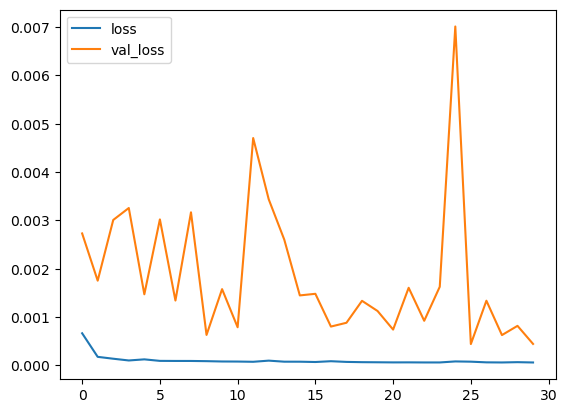

In [28]:
#Se busca el numero de epochs que minimiza la perdida con el dataset de validación 
losses1 = pd.DataFrame(model1.history.history)
losses1.plot()

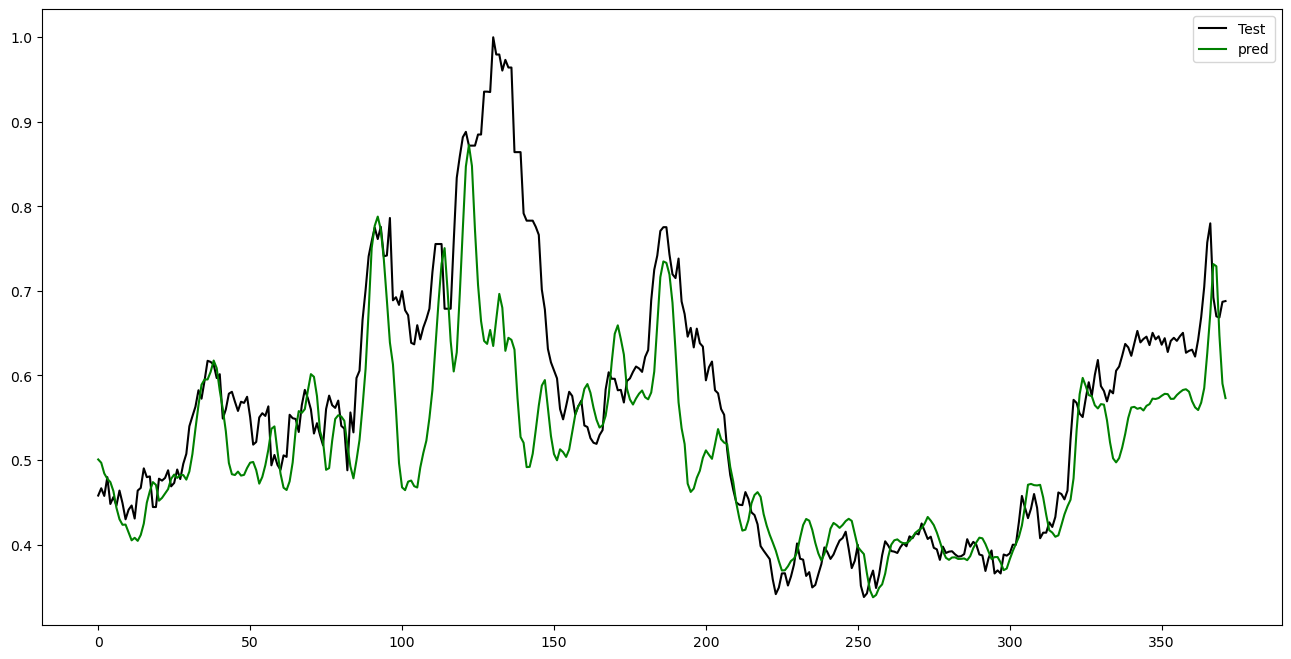

In [29]:
#Predicción
#y_predic=model1.predict(X_test)
modelo1=resumen(1,back,numregressors,losses1.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model1.predict(X_test),LSTM=True,)


In [30]:
modelo1

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,1,40,True,4,29,150,0,0,-0.045018,-16.746725,-0.045018,3.266684,0.0,0.093709,0.06172,9.699019,-697.773804,-682.098228,-691.548607,348.886902


In [31]:
#Modelo 2. Se añade capa oculta


In [32]:
neuronashidden1=150
neuronashidden2=50
neuronashidden3=0

In [33]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model2 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 50)            40200     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 208       
Total params: 133,408
Trainable params: 133,408
Non-trainable params: 0
_________________________________________________________________


In [34]:
#Entrenamiento modelo

In [35]:
%%time
model2.compile(optimizer=adam, loss='mse')
model2.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
89/89 [==============================] - 3s 22ms/step - loss: 0.0019 - val_loss: 0.0039
Epoch 2/30
89/89 [==============================] - 2s 17ms/step - loss: 3.1679e-04 - val_loss: 0.0088
Epoch 3/30
89/89 [==============================] - 1s 16ms/step - loss: 2.4850e-04 - val_loss: 0.0132
Epoch 4/30
89/89 [==============================] - 1s 17ms/step - loss: 1.7830e-04 - val_loss: 0.0122
Epoch 5/30
89/89 [==============================] - 2s 20ms/step - loss: 1.5370e-04 - val_loss: 0.0039
Epoch 6/30
89/89 [==============================] - 1s 15ms/step - loss: 1.0763e-04 - val_loss: 0.0078
Epoch 7/30
89/89 [==============================] - 2s 17ms/step - loss: 1.1671e-04 - val_loss: 0.0056
Epoch 8/30
89/89 [==============================] - 2s 18ms/step - loss: 1.2113e-04 - val_loss: 0.0058
Epoch 9/30
89/89 [==============================] - 1s 15ms/step - loss: 1.2334e-04 - val_loss: 0.0025
Epoch 10/30
89/89 [==============================] - 2s 18ms/step - loss: 1.0

<AxesSubplot:>

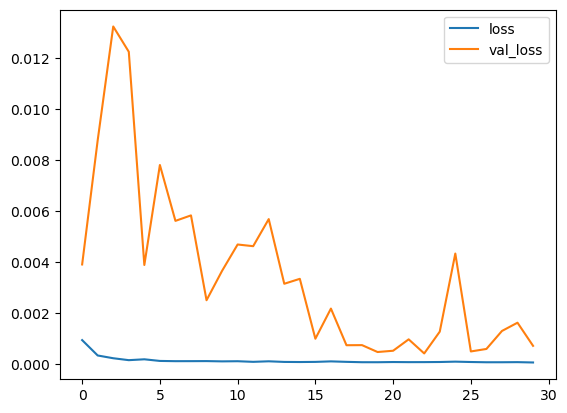

In [36]:
losses2 = pd.DataFrame(model2.history.history)
losses2.plot()

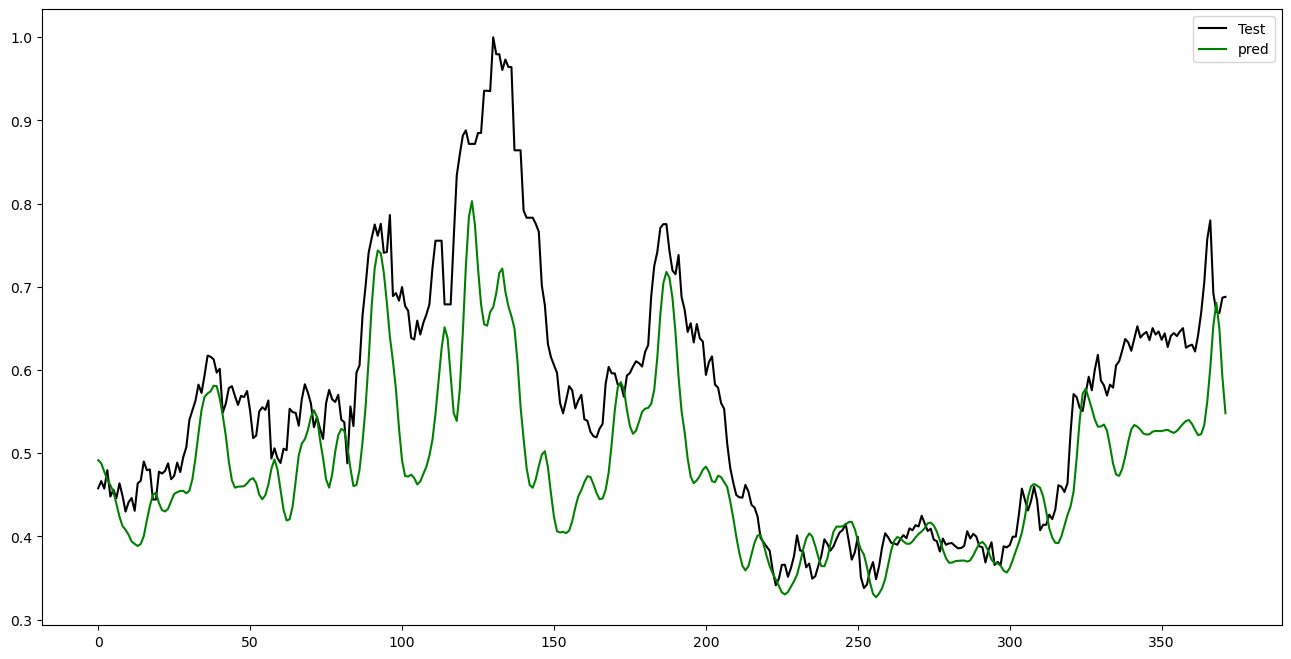

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,2,40,True,4,29,150,50,0,-0.076645,-28.512005,-0.076645,4.501501,1.110223e-16,0.110004,0.081353,12.933689,-578.497398,-562.821823,-572.272202,289.248699


In [37]:
modelo2=resumen(2,back,numregressors,losses2.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model2.predict(X_test),LSTM=True)
modelo2

In [38]:
#Modelo 3
#Se añaden mas neuronas a la segunda oculta

neuronashidden1=150
neuronashidden2=150
neuronashidden3=0

In [39]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model3 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 274,208
Trainable params: 274,208
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time
model3.compile(optimizer=adam, loss='mse')
model3.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
89/89 [==============================] - 3s 22ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 2/30
89/89 [==============================] - 2s 20ms/step - loss: 1.7253e-04 - val_loss: 0.0011
Epoch 3/30
89/89 [==============================] - 2s 21ms/step - loss: 1.0739e-04 - val_loss: 0.0025
Epoch 4/30
89/89 [==============================] - 2s 19ms/step - loss: 1.0173e-04 - val_loss: 0.0027
Epoch 5/30
89/89 [==============================] - 2s 20ms/step - loss: 9.9886e-05 - val_loss: 0.0025
Epoch 6/30
89/89 [==============================] - 2s 18ms/step - loss: 7.9668e-05 - val_loss: 0.0022
Epoch 7/30
89/89 [==============================] - 2s 20ms/step - loss: 8.3693e-05 - val_loss: 0.0012
Epoch 8/30
89/89 [==============================] - 2s 19ms/step - loss: 8.6822e-05 - val_loss: 0.0025
Epoch 9/30
89/89 [==============================] - 2s 21ms/step - loss: 9.1785e-05 - val_loss: 5.7975e-04
Epoch 10/30
89/89 [==============================] - 2s 17ms/step - loss:

<AxesSubplot:>

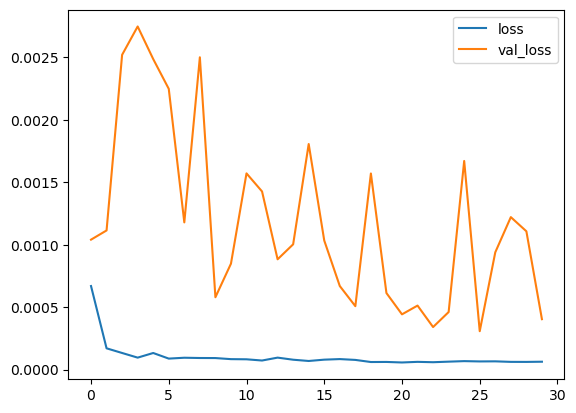

In [41]:
losses3 = pd.DataFrame(model3.history.history)
losses3.plot()

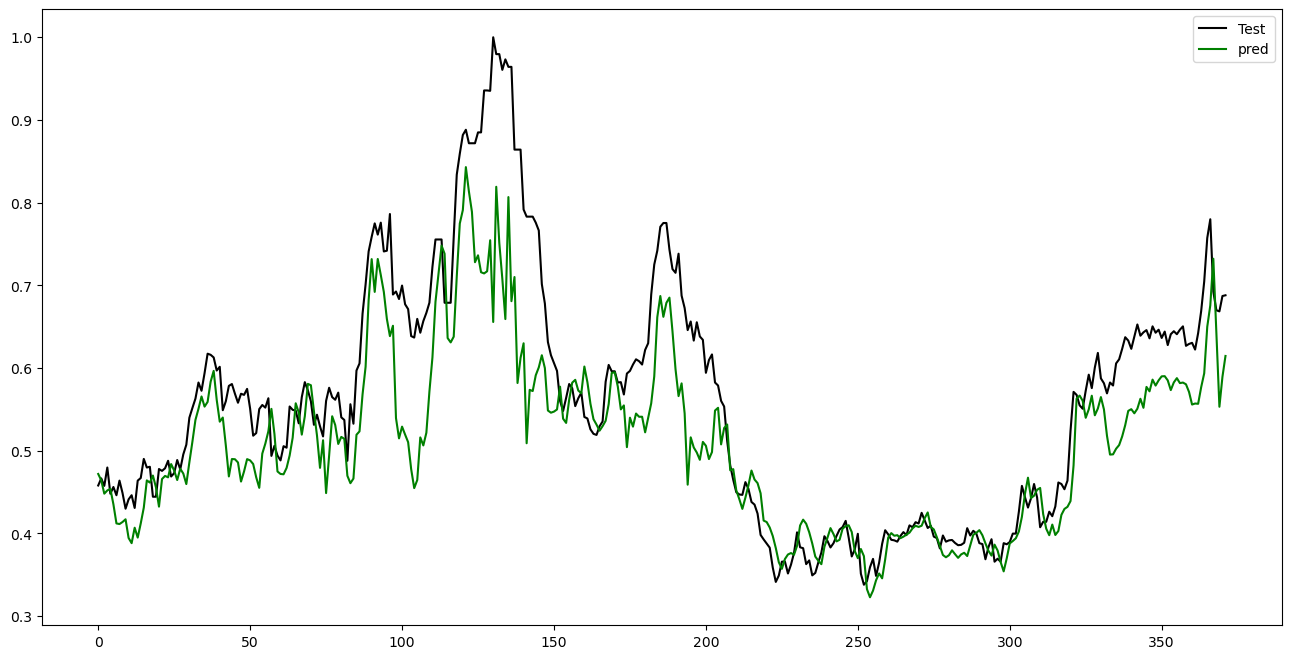

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,3,40,True,4,20,150,150,0,-0.049215,-18.307968,-0.049215,2.49475,0.0,0.081892,0.057592,9.082846,-798.060142,-782.384566,-791.834945,399.030071


In [42]:
modelo3=resumen(3,back,numregressors,losses3.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model3.predict(X_test),LSTM=True)
modelo3

In [43]:
#Modelo 4

neuronashidden1=150
neuronashidden2=150
neuronashidden3=50

In [44]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model4 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 454,808
Trainable params: 454,808
Non-trainable params: 0
_________________________________________________________________


In [45]:
%%time
model4.compile(optimizer=adam, loss='mse')
model4.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
89/89 [==============================] - 4s 28ms/step - loss: 0.0020 - val_loss: 0.0099
Epoch 2/30
89/89 [==============================] - 2s 21ms/step - loss: 5.1901e-04 - val_loss: 0.0165
Epoch 3/30
89/89 [==============================] - 2s 22ms/step - loss: 4.1812e-04 - val_loss: 0.0150
Epoch 4/30
89/89 [==============================] - 2s 22ms/step - loss: 2.4175e-04 - val_loss: 0.0158
Epoch 5/30
89/89 [==============================] - 2s 22ms/step - loss: 2.1564e-04 - val_loss: 0.0058
Epoch 6/30
89/89 [==============================] - 2s 22ms/step - loss: 1.7834e-04 - val_loss: 0.0036
Epoch 7/30
89/89 [==============================] - 2s 21ms/step - loss: 1.4667e-04 - val_loss: 0.0037
Epoch 8/30
89/89 [==============================] - 2s 26ms/step - loss: 1.3486e-04 - val_loss: 0.0051
Epoch 9/30
89/89 [==============================] - 2s 22ms/step - loss: 1.2466e-04 - val_loss: 0.0015
Epoch 10/30
89/89 [==============================] - 2s 23ms/step - loss: 1.1

<AxesSubplot:>

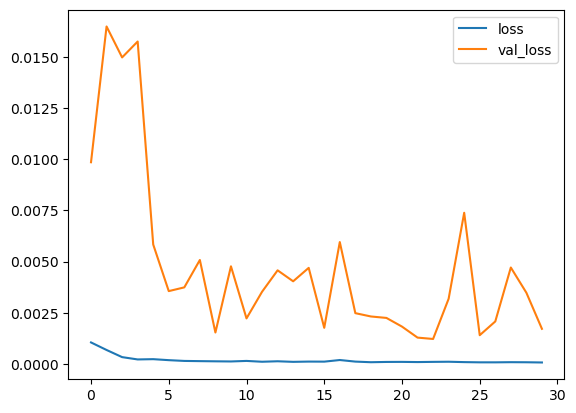

In [46]:
losses4 = pd.DataFrame(model4.history.history)
losses4.plot()

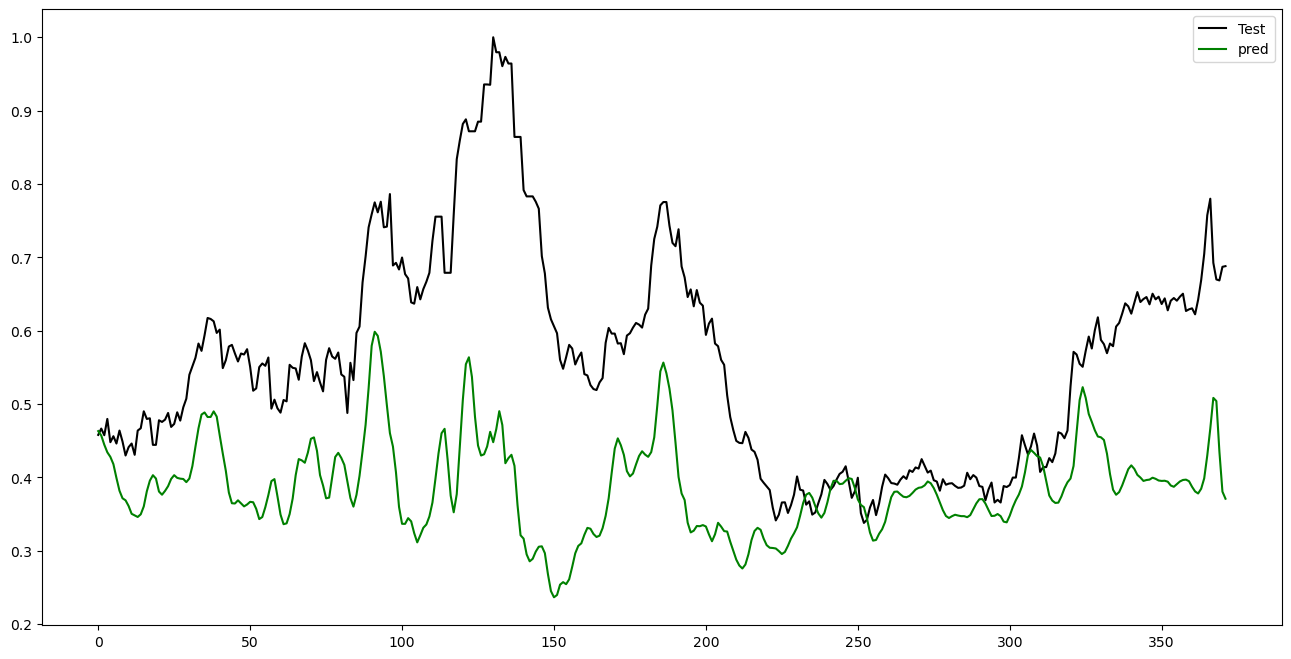

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,4,40,True,4,29,150,150,50,-0.172549,-64.18832,-0.172549,17.648315,6.164947e-08,0.217811,0.173413,27.611815,-70.260043,-54.584468,-64.034847,35.130022


In [47]:
modelo4=resumen(4,back,numregressors,losses4.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model4.predict(X_test),LSTM=True)
modelo4

In [48]:
#Modelo 5

neuronashidden1=150
neuronashidden2=150
neuronashidden3=150

In [49]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model5 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model5.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 4)]           0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           93000     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 454,808
Trainable params: 454,808
Non-trainable params: 0
_________________________________________________________________


In [50]:
%%time
model5.compile(optimizer=adam, loss='mse')
model5.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
89/89 [==============================] - 4s 28ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 2/30
89/89 [==============================] - 2s 22ms/step - loss: 2.5349e-04 - val_loss: 0.0047
Epoch 3/30
89/89 [==============================] - 2s 21ms/step - loss: 1.8956e-04 - val_loss: 0.0157
Epoch 4/30
89/89 [==============================] - 2s 22ms/step - loss: 2.1607e-04 - val_loss: 0.0073
Epoch 5/30
89/89 [==============================] - 2s 23ms/step - loss: 1.4109e-04 - val_loss: 0.0075
Epoch 6/30
89/89 [==============================] - 2s 22ms/step - loss: 1.4339e-04 - val_loss: 0.0059
Epoch 7/30
89/89 [==============================] - 2s 22ms/step - loss: 1.0916e-04 - val_loss: 0.0036
Epoch 8/30
89/89 [==============================] - 2s 23ms/step - loss: 1.1455e-04 - val_loss: 0.0047
Epoch 9/30
89/89 [==============================] - 2s 22ms/step - loss: 1.1305e-04 - val_loss: 9.6652e-04
Epoch 10/30
89/89 [==============================] - 2s 24ms/step - loss:

<AxesSubplot:>

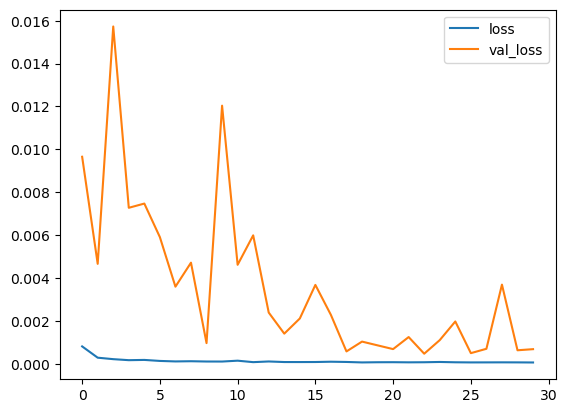

In [51]:
losses5 = pd.DataFrame(model5.history.history)
losses5.plot()

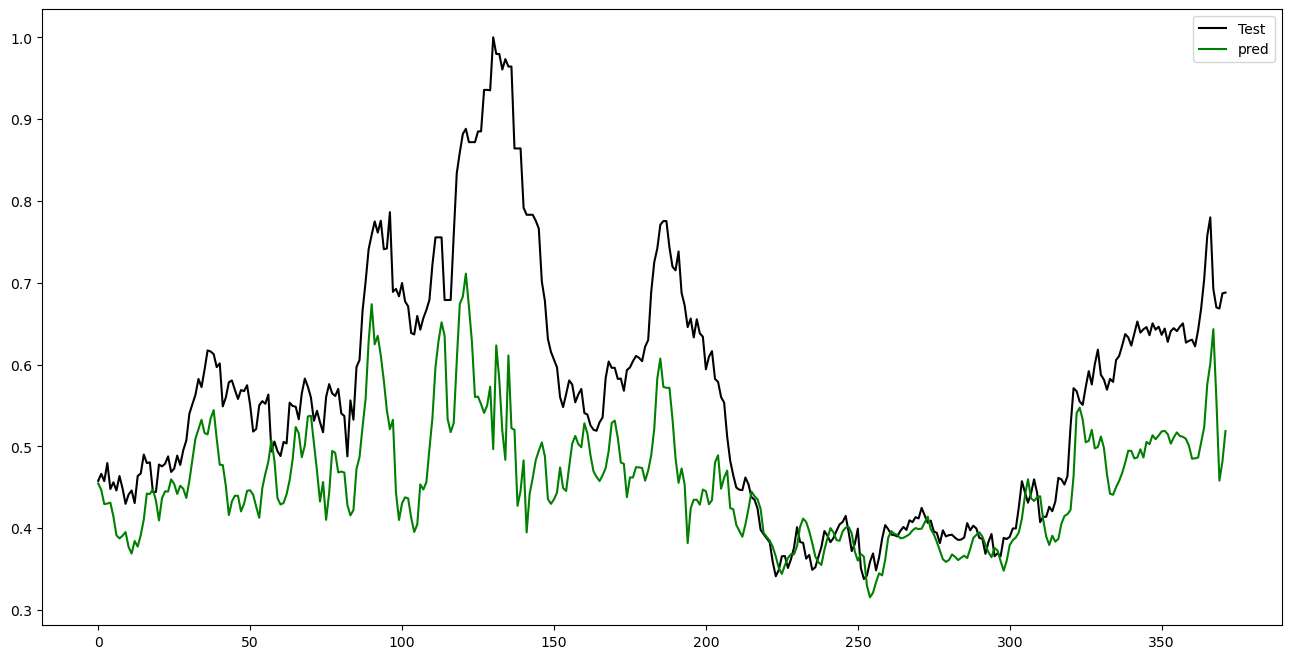

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,5,40,True,4,29,150,150,150,-0.101445,-37.737595,-0.101445,7.533635,0.0,0.142308,0.104172,16.082753,-386.929739,-371.254164,-380.704543,193.46487


In [52]:
modelo5=resumen(5,back,numregressors,losses5.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model5.predict(X_test),LSTM=True)
modelo5

In [53]:
'''
Se añaden a las mismas arquitecturas de red regresores adicionales.
Es necesario volver a importar los datos ya que han sido modificados
'''

'\nSe añaden a las mismas arquitecturas de red regresores adicionales.\nEs necesario volver a importar los datos ya que han sido modificados\n'

In [54]:
#Descarga de datos
data = yf.download(tickers = 'REP.MC', start = '1987-06-12',end = today)

[*********************100%***********************]  1 of 1 completed


In [55]:
#Se añade índice bursatil Relative Strength Index al dataset y medias móviles

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

# Se crean campos personalizados para añadir las diferencias entre precio de apertura y cierre, la diferencia del dia anterior
#además de una clase binaria si la diferencia es positiva o negativa

data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)


data.reset_index(inplace = True)
#Elimino fecha y cierre ajunstado por ser igual en muchos casos al precio de cierre que se pretende predecir
data.drop(['Date','Adj Close'],axis=1, inplace=True)
data.dropna(inplace=True)
#Obtener de manera automatica el nuḿero de variables a evaluar 
#Todos los valores excepto el precio de cierre que es lo que se pretende predecir
numregressors=data.shape[1]-1

dataClose=data.loc[:, data.columns == 'Close']
data=data.loc[:, data.columns != 'Close']
data=pd.concat([data,dataClose],axis=1)


In [56]:
data

,Open,High,Low,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,Close
149,20.420000,20.650000,20.350000,3419068,47.368476,20.891064,21.138611,21.205067,-0.160002,0,20.209999,20.370001
150,20.370001,20.490000,20.000000,3535782,46.735201,20.826201,21.120223,21.191887,0.599998,1,20.959999,20.209999
151,20.360001,21.049999,20.360001,5981034,50.086553,20.838944,21.117050,21.188816,0.000000,0,21.100000,20.959999
152,21.100000,21.290001,21.000000,5425462,50.706851,20.863806,21.116713,21.187639,0.020000,1,21.170000,21.100000
153,21.150000,21.360001,21.150000,3157556,51.032849,20.892967,21.117768,21.187406,-0.010000,0,21.440001,21.170000
...,...,...,...,...,...,...,...,...,...,...,...,...
5918,13.760000,13.870000,13.620000,8812888,40.882076,14.075539,14.326474,14.141729,-0.075000,0,13.535000,13.700000
5919,13.610000,13.715000,13.445000,4231844,38.477286,14.024059,14.310802,14.133693,-0.190000,0,13.310000,13.535000
5920,13.500000,13.580000,13.300000,5285958,35.432176,13.956054,14.290984,14.122783,-0.025000,0,13.340000,13.310000
5921,13.365000,13.365000,13.185000,5282325,36.154000,13.897382,14.272152,14.112415,0.415000,1,13.615000,13.340000


In [57]:
#debido al gran número de parámetros y la diferencia de magnitudes se estandarizan los datos para homegeneizar y obtener
#mejores resultados.
#Importante, estandarizo con datos de entrenamiento y lo aplico a test

'''
La estandarización de los datos implica escalar los valores de entrada
para que tengan una media de cero y una desviación estándar de uno.
Esto ayuda a nivelar las diferencias en la escala y distribución de los datos,
lo que puede facilitar el proceso de aprendizaje de la red neuronal y mejorar su capacidad
para generalizar y hacer predicciones precisas en nuevos datos.
'''
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data)


In [58]:
X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


5774


In [59]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud
ndias=y_test.shape[0]


4587
(4587, 40, 11)
(1147, 40, 11)
(4587, 1)
(1147, 1)


In [60]:
#Creacion primera red neuronal Modelo1 de una sola capa oculta
neuronashidden1=150
neuronashidden2=0
neuronashidden3=0

In [61]:
# Entrada y salida
lstm_input = Input(shape=(back, numregressors), name='lstm_input')
inputs = LSTM(neuronashidden1, name='HiddenLayer1',return_sequences=True)(lstm_input)
output=LSTM(1,activation='linear',name ='Output_Layer')(inputs)
model6 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model6.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 11)]          0         
_________________________________________________________________
HiddenLayer1 (LSTM)          (None, 40, 150)           97200     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 97,808
Trainable params: 97,808
Non-trainable params: 0
_________________________________________________________________


In [62]:
%%time
model6.compile(optimizer=adam, loss='mse')
model6.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)


Epoch 1/30
276/276 [==============================] - 7s 23ms/step - loss: 0.0150 - val_loss: 1.0722e-04
Epoch 2/30
276/276 [==============================] - 6s 21ms/step - loss: 2.8387e-04 - val_loss: 8.4978e-05
Epoch 3/30
276/276 [==============================] - 6s 20ms/step - loss: 2.4762e-04 - val_loss: 9.7637e-05
Epoch 4/30
276/276 [==============================] - 6s 20ms/step - loss: 1.8832e-04 - val_loss: 1.0978e-04
Epoch 5/30
276/276 [==============================] - 6s 21ms/step - loss: 1.4968e-04 - val_loss: 6.1919e-05
Epoch 6/30
276/276 [==============================] - 6s 21ms/step - loss: 1.2227e-04 - val_loss: 4.7725e-05
Epoch 7/30
276/276 [==============================] - 6s 22ms/step - loss: 1.5342e-04 - val_loss: 1.1603e-04
Epoch 8/30
276/276 [==============================] - 6s 21ms/step - loss: 1.1574e-04 - val_loss: 4.9839e-05
Epoch 9/30
276/276 [==============================] - 6s 23ms/step - loss: 1.0840e-04 - val_loss: 3.8009e-05
Epoch 10/30
276/276 [==

<AxesSubplot:>

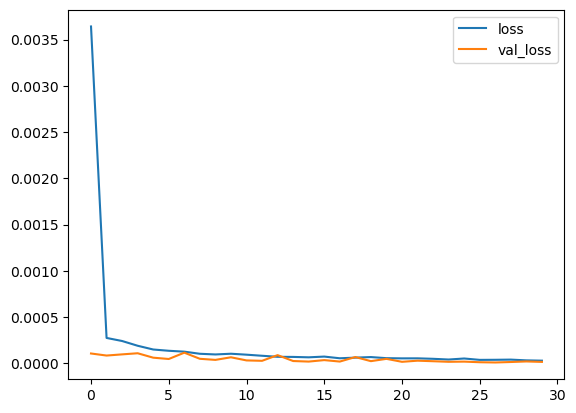

In [63]:
#Se busba el numero de epochs que minimiza la perdida con el dataset de validación 
losses6 = pd.DataFrame(model6.history.history)
losses6.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


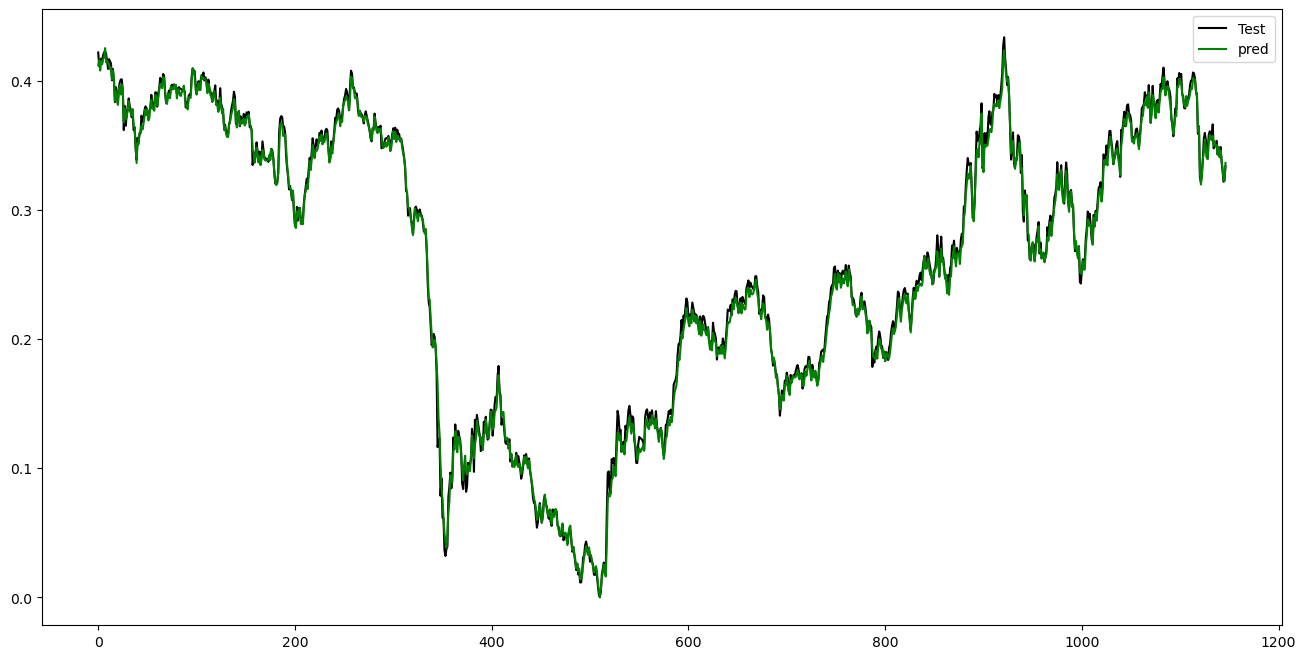

In [64]:
#Predicción
modelo6=resumen(6,back,numregressors,losses6.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model6.predict(X_test),LSTM=True,)


In [65]:
#Añadir capa oculta
neuronashidden1=150
neuronashidden2=50
neuronashidden3=0

In [66]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model7 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model7.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 11)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           97200     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 50)            40200     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 208       
Total params: 137,608
Trainable params: 137,608
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Entrenamiento modelo

In [68]:
%%time
model7.compile(optimizer=adam, loss='mse')
model7.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 10s 30ms/step - loss: 6.6503 - val_loss: 0.0068
Epoch 2/30
276/276 [==============================] - 7s 26ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 3/30
276/276 [==============================] - 7s 25ms/step - loss: 0.0038 - val_loss: 0.0021
Epoch 4/30
276/276 [==============================] - 7s 25ms/step - loss: 0.0026 - val_loss: 7.4924e-04
Epoch 5/30
276/276 [==============================] - 7s 27ms/step - loss: 0.0019 - val_loss: 6.0966e-04
Epoch 6/30
276/276 [==============================] - 8s 28ms/step - loss: 0.0016 - val_loss: 4.2782e-04
Epoch 7/30
276/276 [==============================] - 8s 28ms/step - loss: 0.0013 - val_loss: 3.5779e-04
Epoch 8/30
276/276 [==============================] - 8s 28ms/step - loss: 0.0012 - val_loss: 3.0977e-04
Epoch 9/30
276/276 [==============================] - 7s 26ms/step - loss: 0.0013 - val_loss: 4.0487e-04
Epoch 10/30
276/276 [==============================] - 7s 24ms/ste

<AxesSubplot:>

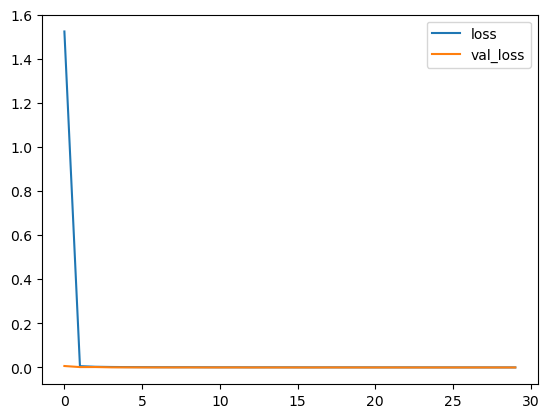

In [69]:
losses7 = pd.DataFrame(model7.history.history)
losses7.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


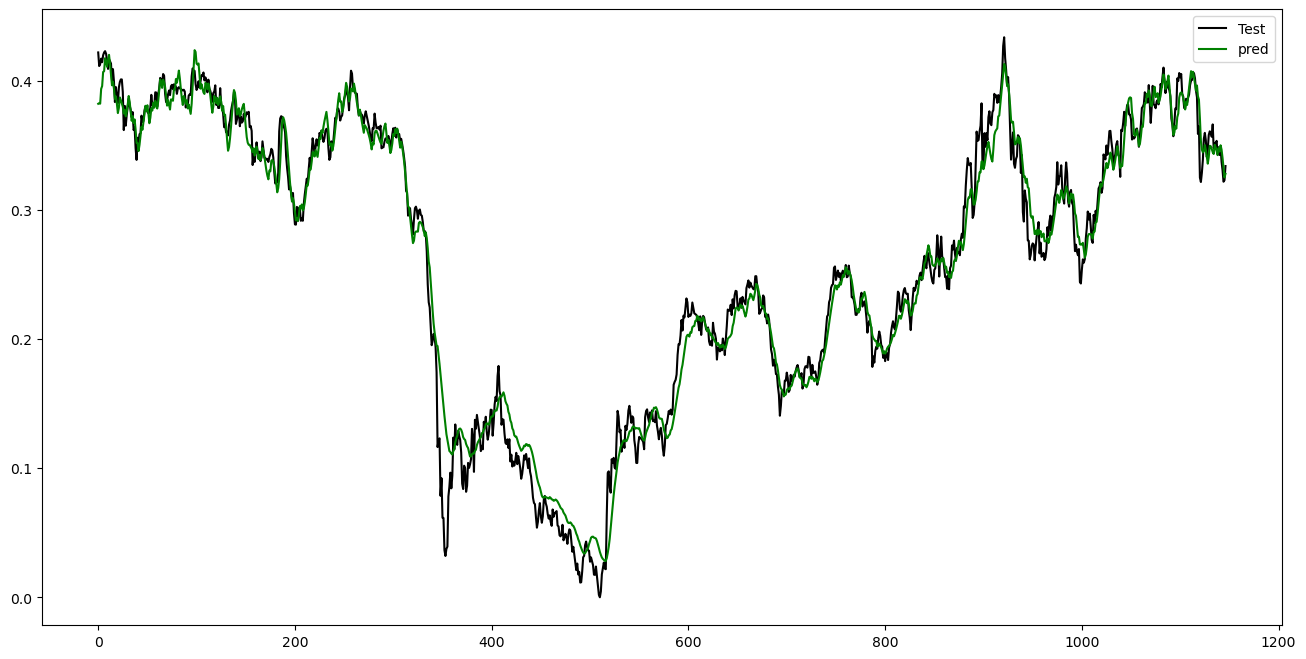

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,7,40,True,11,27,150,50,0,0.000092,0.105634,0.000092,0.310181,0.0,0.016445,0.011498,inf,-6146.139081,-6090.645125,-6125.188378,3073.069541


In [70]:
modelo7=resumen(7,back,numregressors,losses7.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model7.predict(X_test),LSTM=True)
modelo7

In [71]:
#Añadir capa oculta
neuronashidden1=150
neuronashidden2=150
neuronashidden3=0

In [72]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model8 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model8.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 11)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           97200     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 278,408
Trainable params: 278,408
Non-trainable params: 0
_________________________________________________________________


In [73]:
#Entrenamiento modelo

In [74]:
%%time
model8.compile(optimizer=adam, loss='mse')
model8.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 11s 35ms/step - loss: 0.0141 - val_loss: 3.2774e-04
Epoch 2/30
276/276 [==============================] - 9s 33ms/step - loss: 6.1338e-04 - val_loss: 1.4323e-04
Epoch 3/30
276/276 [==============================] - 8s 29ms/step - loss: 5.1801e-04 - val_loss: 1.2658e-04
Epoch 4/30
276/276 [==============================] - 8s 29ms/step - loss: 4.4933e-04 - val_loss: 9.6170e-05
Epoch 5/30
276/276 [==============================] - 8s 29ms/step - loss: 3.0451e-04 - val_loss: 1.0480e-04
Epoch 6/30
276/276 [==============================] - 8s 30ms/step - loss: 2.3742e-04 - val_loss: 1.4802e-04
Epoch 7/30
276/276 [==============================] - 10s 35ms/step - loss: 2.5734e-04 - val_loss: 6.8967e-05
Epoch 8/30
276/276 [==============================] - 9s 32ms/step - loss: 1.8635e-04 - val_loss: 2.5962e-04
Epoch 9/30
276/276 [==============================] - 8s 31ms/step - loss: 1.7964e-04 - val_loss: 1.4372e-04
Epoch 10/30
276/276 [

<AxesSubplot:>

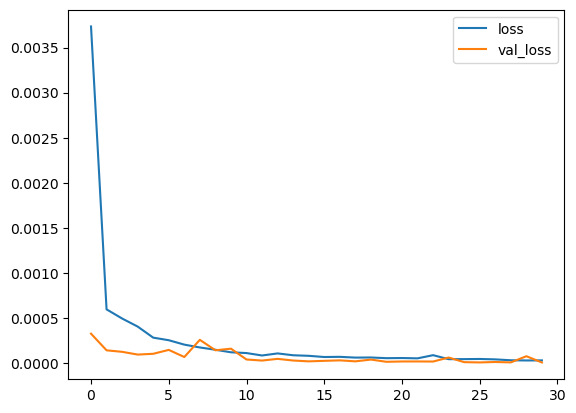

In [75]:
losses8 = pd.DataFrame(model8.history.history)
losses8.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


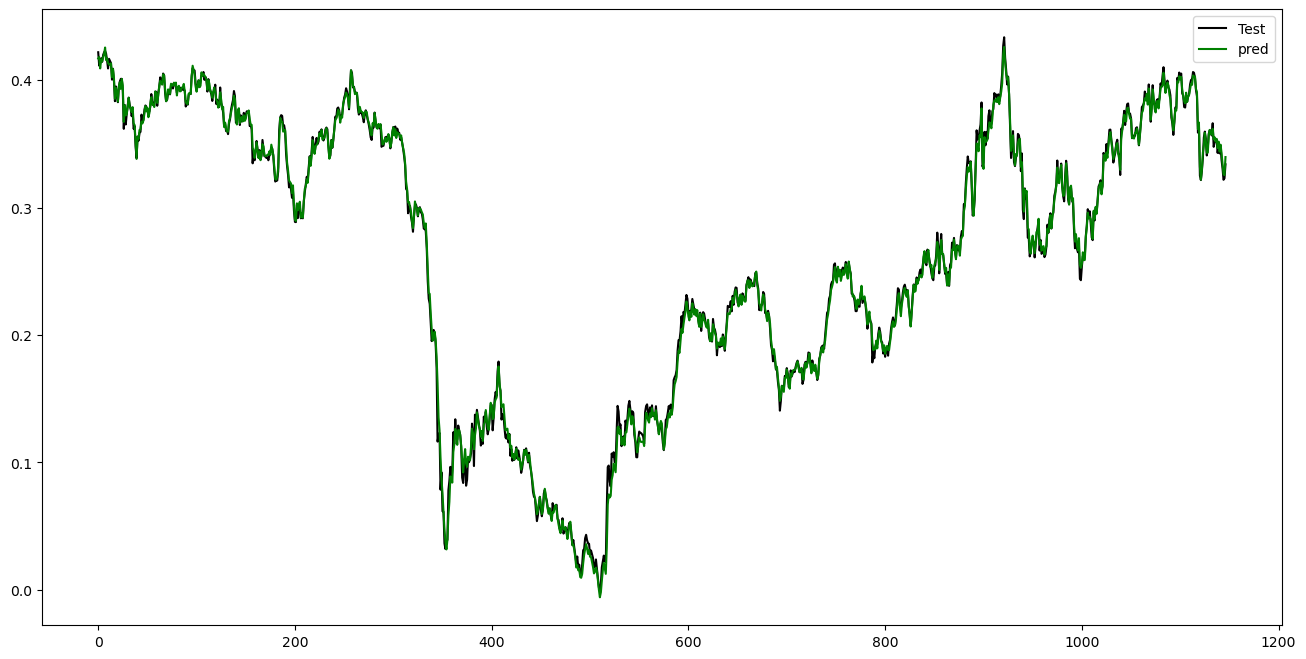

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,8,40,True,11,28,150,150,0,-0.000593,-0.679604,-0.000593,0.024113,0.0,0.004585,0.003121,inf,-9076.037027,-9020.543071,-9055.086325,4538.018514


In [76]:
modelo8=resumen(8,back,numregressors,losses8.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model8.predict(X_test),LSTM=True)
modelo8

In [77]:
#Modelo 9

neuronashidden1=150
neuronashidden2=150
neuronashidden3=50

In [78]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model9= Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model9.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 11)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           97200     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 459,008
Trainable params: 459,008
Non-trainable params: 0
_________________________________________________________________


In [79]:
%%time
model9.compile(optimizer=adam, loss='mse')
model9.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 12s 34ms/step - loss: 0.0185 - val_loss: 3.3006e-04
Epoch 2/30
276/276 [==============================] - 9s 32ms/step - loss: 0.0012 - val_loss: 2.3937e-04
Epoch 3/30
276/276 [==============================] - 9s 32ms/step - loss: 8.9792e-04 - val_loss: 4.3207e-04
Epoch 4/30
276/276 [==============================] - 9s 32ms/step - loss: 7.7592e-04 - val_loss: 1.3914e-04
Epoch 5/30
276/276 [==============================] - 9s 32ms/step - loss: 5.0090e-04 - val_loss: 1.5974e-04
Epoch 6/30
276/276 [==============================] - 9s 32ms/step - loss: 3.3076e-04 - val_loss: 2.1244e-04
Epoch 7/30
276/276 [==============================] - 8s 30ms/step - loss: 3.1182e-04 - val_loss: 6.9479e-05
Epoch 8/30
276/276 [==============================] - 8s 30ms/step - loss: 2.5867e-04 - val_loss: 2.0306e-04
Epoch 9/30
276/276 [==============================] - 9s 32ms/step - loss: 1.7234e-04 - val_loss: 1.0007e-04
Epoch 10/30
276/276 [=====

<AxesSubplot:>

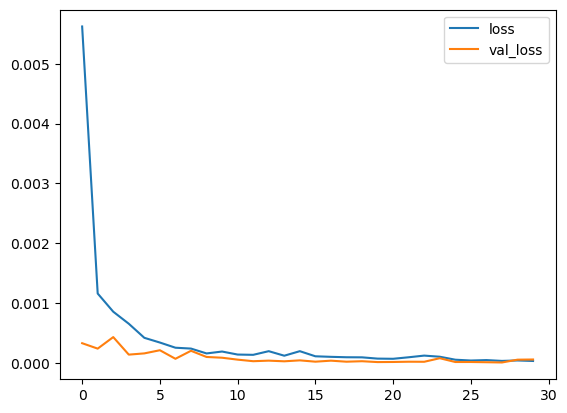

In [80]:
losses9 = pd.DataFrame(model9.history.history)
losses9.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


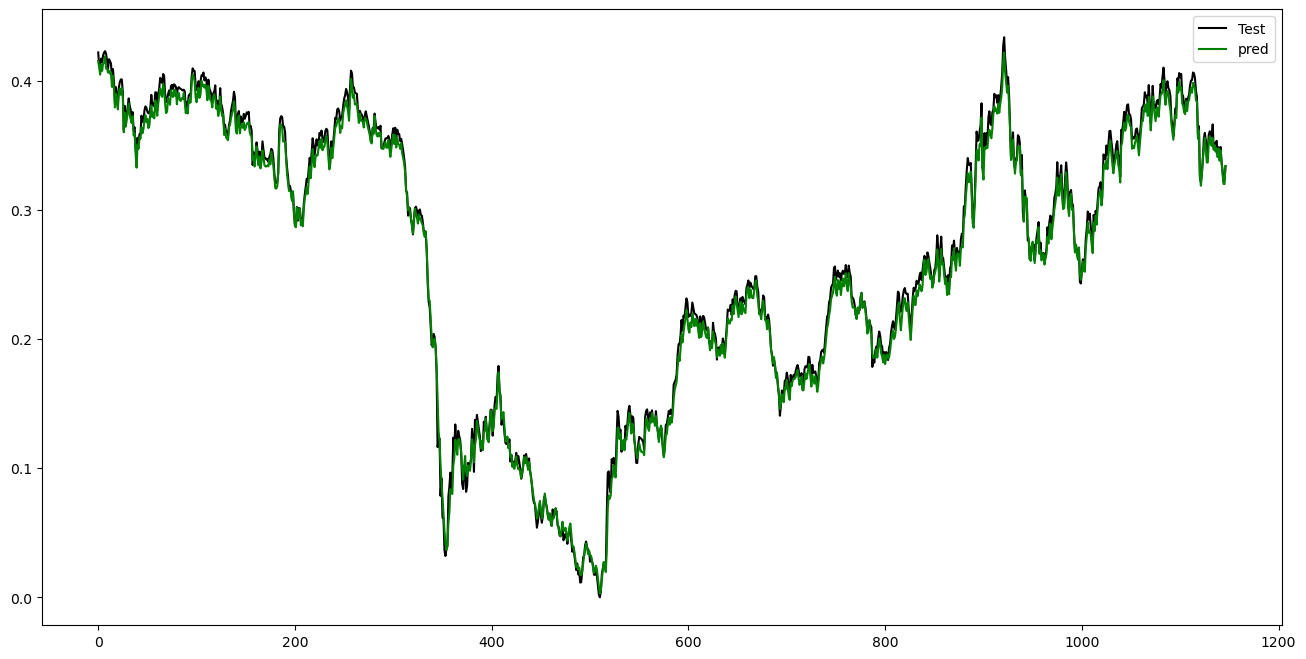

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,9,40,True,11,29,150,150,50,-0.004805,-5.511066,-0.004805,0.05321,0.0,0.006811,0.005734,inf,-8168.192599,-8112.698643,-8147.241896,4084.096299


In [81]:
modelo9=resumen(9,back,numregressors,losses9.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model9.predict(X_test),LSTM=True)
modelo9

In [82]:
#Modelo 10

neuronashidden1=150
neuronashidden2=150
neuronashidden3=150

In [83]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model10 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model10.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 11)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           97200     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 459,008
Trainable params: 459,008
Non-trainable params: 0
_________________________________________________________________


In [84]:
%%time
model10.compile(optimizer=adam, loss='mse')
model10.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 12s 34ms/step - loss: 0.0437 - val_loss: 2.8819e-04
Epoch 2/30
276/276 [==============================] - 9s 31ms/step - loss: 0.0010 - val_loss: 2.9451e-04
Epoch 3/30
276/276 [==============================] - 8s 29ms/step - loss: 8.3399e-04 - val_loss: 2.3750e-04
Epoch 4/30
276/276 [==============================] - 8s 28ms/step - loss: 7.3817e-04 - val_loss: 1.9131e-04
Epoch 5/30
276/276 [==============================] - 8s 29ms/step - loss: 5.5056e-04 - val_loss: 3.1231e-04
Epoch 6/30
276/276 [==============================] - 8s 28ms/step - loss: 4.0536e-04 - val_loss: 5.1466e-04
Epoch 7/30
276/276 [==============================] - 8s 29ms/step - loss: 4.3663e-04 - val_loss: 1.2018e-04
Epoch 8/30
276/276 [==============================] - 8s 29ms/step - loss: 2.4388e-04 - val_loss: 1.9575e-04
Epoch 9/30
276/276 [==============================] - 8s 28ms/step - loss: 2.0737e-04 - val_loss: 4.6241e-05
Epoch 10/30
276/276 [=====

<AxesSubplot:>

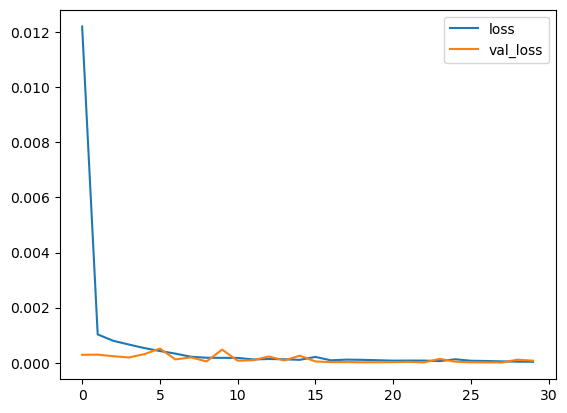

In [85]:
losses10 = pd.DataFrame(model10.history.history)
losses10.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


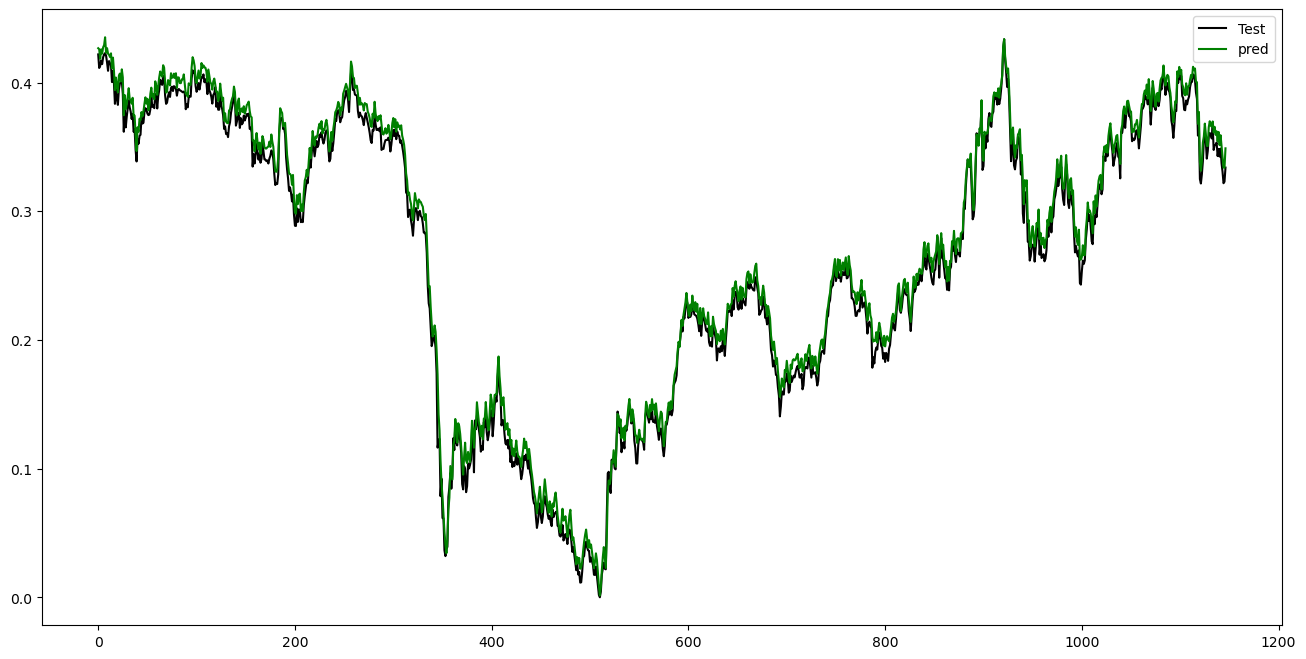

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,10,40,True,11,29,150,150,150,0.008276,9.492453,0.008276,0.100682,0.0,0.009369,0.008461,inf,-7436.727832,-7381.233876,-7415.777129,3718.363916


In [86]:
modelo10=resumen(10,back,numregressors,losses10.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model10.predict(X_test),LSTM=True)
modelo10

In [87]:
'''
Se añaden a todos los datos anteriores la  rentabilidad y rentabilidad acumulada aplicando las mismas arquitecturas de red y 

'''

'\nSe añaden a todos los datos anteriores la  rentabilidad y rentabilidad acumulada aplicando las mismas arquitecturas de red y \n\n'

In [88]:
#Descarga de datos
data = yf.download(tickers = 'REP.MC', start = '1987-06-12',end = today)

[*********************100%***********************]  1 of 1 completed


In [89]:
#Se añade índice bursatil Relative Strength Index al dataset y medias móviles

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

# Se crean campos personalizados para añadir las diferencias entre precio de apertura y cierre, la diferencia del dia anterior
#además de una clase binaria si la diferencia es positiva o negativa

data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

#Se añade rentabilidad por registro y rentabilidad acumulada
data['Rentabilidad']=((data['Adj Close'].shift(1)-data['Adj Close'])/data['Adj Close'])*100
data['RentabilidadAcum']=np.cumsum(data['Rentabilidad'])
data.reset_index(inplace = True)
#Elimino fecha y cierre ajunstado por ser igual en muchos casos al precio de cierre que se pretende predecir
data.drop(['Date','Adj Close'],axis=1, inplace=True)
data.dropna(inplace=True)
#Obtener de manera automatica el nuḿero de variables a evaluar 
#Todos los valores excepto el precio de cierre que es lo que se pretende predecir
numregressors=data.shape[1]-1

dataClose=data.loc[:, data.columns == 'Close']
data=data.loc[:, data.columns != 'Close']
data=pd.concat([data,dataClose],axis=1)


In [90]:
data

,Open,High,Low,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,Rentabilidad,RentabilidadAcum,Close
149,20.420000,20.650000,20.350000,3419068,47.368476,20.891064,21.138611,21.205067,-0.160002,0,20.209999,0.638184,15.998369,20.370001
150,20.370001,20.490000,20.000000,3535782,46.735201,20.826201,21.120223,21.191887,0.599998,1,20.959999,0.791708,16.790078,20.209999
151,20.360001,21.049999,20.360001,5981034,50.086553,20.838944,21.117050,21.188816,0.000000,0,21.100000,-3.578244,13.211833,20.959999
152,21.100000,21.290001,21.000000,5425462,50.706851,20.863806,21.116713,21.187639,0.020000,1,21.170000,-0.663527,12.548307,21.100000
153,21.150000,21.360001,21.150000,3157556,51.032849,20.892967,21.117768,21.187406,-0.010000,0,21.440001,-0.330631,12.217676,21.170000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,13.760000,13.870000,13.620000,8812888,40.882076,14.075539,14.326474,14.141729,-0.075000,0,13.535000,2.080291,52.819899,13.700000
5919,13.610000,13.715000,13.445000,4231844,38.477286,14.024059,14.310802,14.133693,-0.190000,0,13.310000,1.219061,54.038961,13.535000
5920,13.500000,13.580000,13.300000,5285958,35.432176,13.956054,14.290984,14.122783,-0.025000,0,13.340000,1.690454,55.729415,13.310000
5921,13.365000,13.365000,13.185000,5282325,36.154000,13.897382,14.272152,14.112415,0.415000,1,13.615000,-0.224886,55.504529,13.340000


In [91]:
#debido al gran número de parámetros y la diferencia de magnitudes se estandarizan los datos para homegeneizar y obtener
#mejores resultados.
#Importante, estandarizo con datos de entrenamiento y lo aplico a test

'''
La estandarización de los datos implica escalar los valores de entrada
para que tengan una media de cero y una desviación estándar de uno.
Esto ayuda a nivelar las diferencias en la escala y distribución de los datos,
lo que puede facilitar el proceso de aprendizaje de la red neuronal y mejorar su capacidad
para generalizar y hacer predicciones precisas en nuevos datos.
'''
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data)


In [92]:
X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


5774


In [93]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud
ndias=y_test.shape[0]


4587
(4587, 40, 13)
(1147, 40, 13)
(4587, 1)
(1147, 1)


In [94]:
#Creacion primera red neuronal de una sola capa oculta
#Modelo11
neuronashidden1=150
neuronashidden2=0
neuronashidden3=0

In [95]:
# Entrada y salida
lstm_input = Input(shape=(back, numregressors), name='lstm_input')
inputs = LSTM(neuronashidden1, name='HiddenLayer1',return_sequences=True)(lstm_input)
output=LSTM(1,activation='linear',name ='Output_Layer')(inputs)
model11 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model11.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 13)]          0         
_________________________________________________________________
HiddenLayer1 (LSTM)          (None, 40, 150)           98400     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 99,008
Trainable params: 99,008
Non-trainable params: 0
_________________________________________________________________


In [96]:
%%time
model11.compile(optimizer=adam, loss='mse')
model11.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)


Epoch 1/30
276/276 [==============================] - 7s 22ms/step - loss: 0.0065 - val_loss: 1.5189e-04
Epoch 2/30
276/276 [==============================] - 6s 20ms/step - loss: 4.7685e-04 - val_loss: 3.5307e-04
Epoch 3/30
276/276 [==============================] - 6s 21ms/step - loss: 3.7989e-04 - val_loss: 2.0064e-04
Epoch 4/30
276/276 [==============================] - 6s 21ms/step - loss: 2.6339e-04 - val_loss: 1.1785e-04
Epoch 5/30
276/276 [==============================] - 6s 21ms/step - loss: 1.9497e-04 - val_loss: 9.2802e-05
Epoch 6/30
276/276 [==============================] - 6s 21ms/step - loss: 1.4367e-04 - val_loss: 1.5489e-04
Epoch 7/30
276/276 [==============================] - 6s 20ms/step - loss: 1.7565e-04 - val_loss: 5.4463e-05
Epoch 8/30
276/276 [==============================] - 6s 21ms/step - loss: 1.2301e-04 - val_loss: 7.8421e-05
Epoch 9/30
276/276 [==============================] - 6s 20ms/step - loss: 1.1482e-04 - val_loss: 1.5597e-04
Epoch 10/30
276/276 [==

<AxesSubplot:>

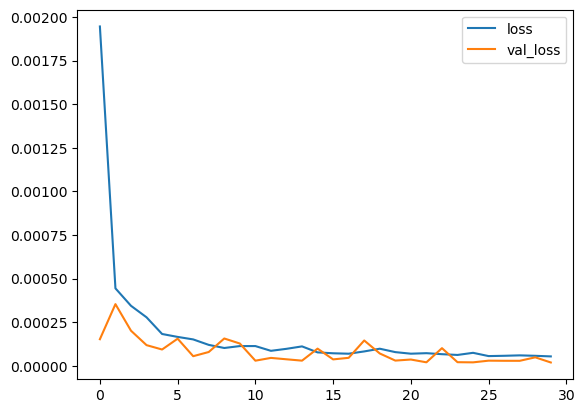

In [97]:
#Se busba el numero de epochs que minimiza la perdida con el dataset de validación 
losses11 = pd.DataFrame(model11.history.history)
losses11.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


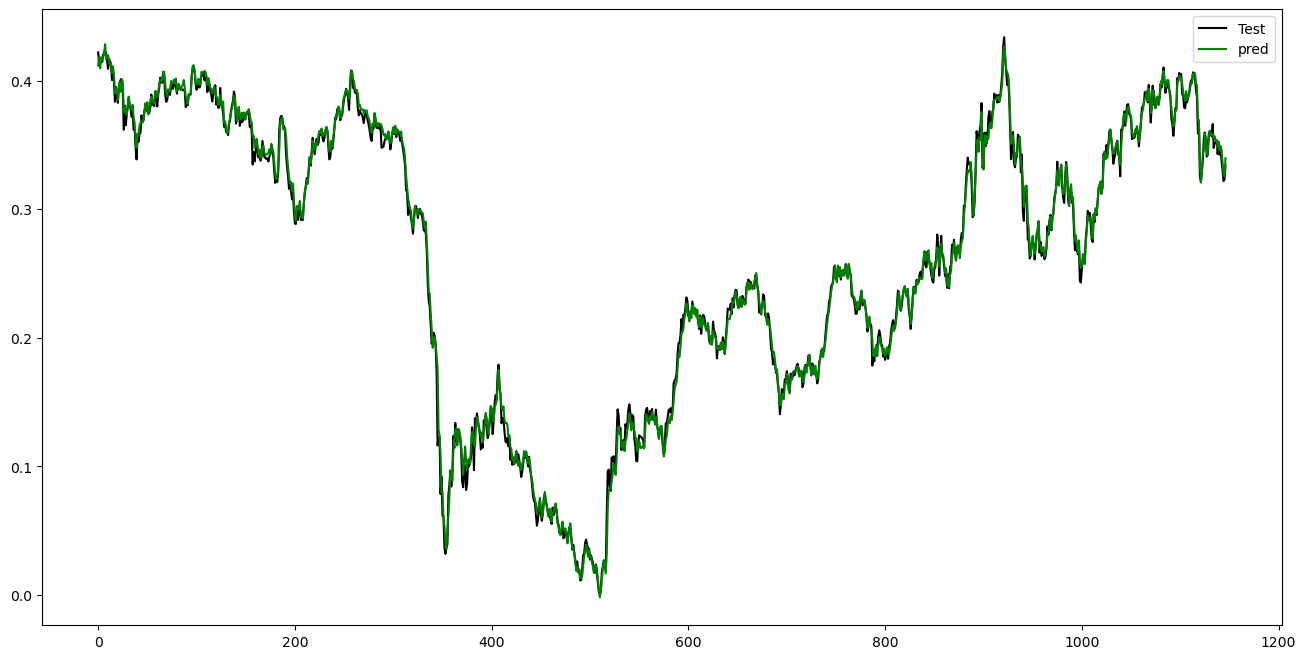

In [98]:
#Predicción
modelo11=resumen(11,back,numregressors,losses11.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model11.predict(X_test),LSTM=True,)


In [99]:
#Añadir capa oculta
neuronashidden1=150
neuronashidden2=50
neuronashidden3=0

In [100]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model12 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model12.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 13)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           98400     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 50)            40200     
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 208       
Total params: 138,808
Trainable params: 138,808
Non-trainable params: 0
_________________________________________________________________


In [101]:
#Entrenamiento modelo

In [102]:
%%time
model12.compile(optimizer=adam, loss='mse')
model12.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 9s 25ms/step - loss: 0.0495 - val_loss: 3.1869e-04
Epoch 2/30
276/276 [==============================] - 6s 23ms/step - loss: 9.2979e-04 - val_loss: 1.9588e-04
Epoch 3/30
276/276 [==============================] - 6s 23ms/step - loss: 7.4364e-04 - val_loss: 7.8639e-04
Epoch 4/30
276/276 [==============================] - 6s 23ms/step - loss: 6.3086e-04 - val_loss: 3.9586e-04
Epoch 5/30
276/276 [==============================] - 6s 23ms/step - loss: 4.8895e-04 - val_loss: 1.1679e-04
Epoch 6/30
276/276 [==============================] - 6s 23ms/step - loss: 4.6872e-04 - val_loss: 1.8565e-04
Epoch 7/30
276/276 [==============================] - 6s 22ms/step - loss: 3.8545e-04 - val_loss: 1.0290e-04
Epoch 8/30
276/276 [==============================] - 6s 23ms/step - loss: 3.4864e-04 - val_loss: 1.2436e-04
Epoch 9/30
276/276 [==============================] - 6s 23ms/step - loss: 3.7719e-04 - val_loss: 2.6606e-04
Epoch 10/30
276/276 [==

<AxesSubplot:>

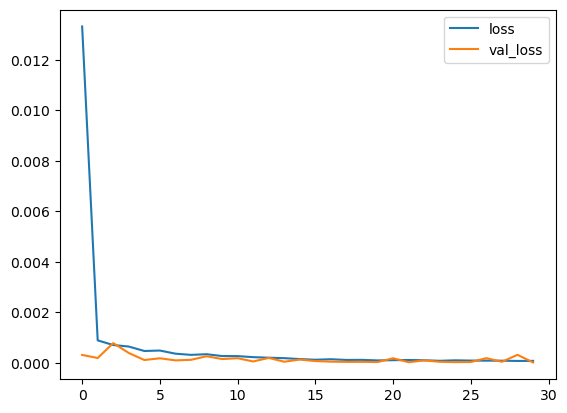

In [103]:
losses12 = pd.DataFrame(model12.history.history)
losses12.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


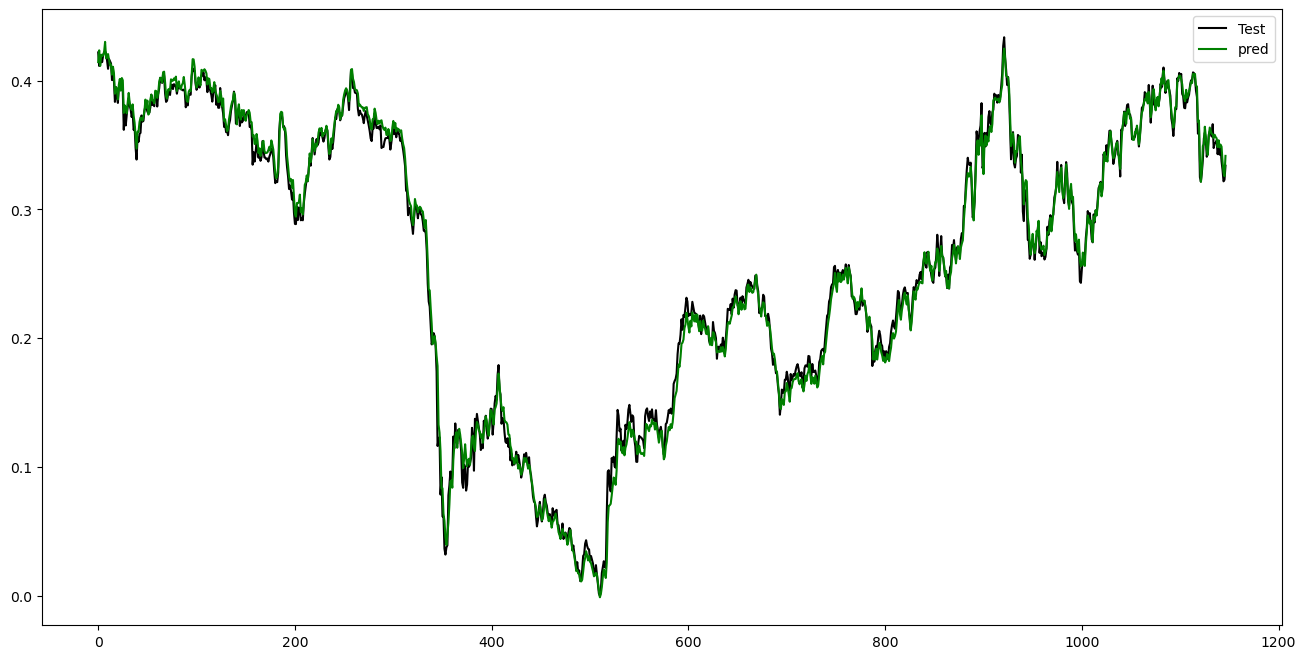

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,12,40,True,13,28,150,50,0,-0.000226,-0.258821,-0.000226,0.066216,0.0,0.007598,0.005663,inf,-7913.376847,-7847.793081,-7888.616926,3956.688424


In [104]:
modelo12=resumen(12,back,numregressors,losses12.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model12.predict(X_test),LSTM=True)
modelo12

In [105]:
#Añadir capa oculta
neuronashidden1=150
neuronashidden2=150
neuronashidden3=0

In [106]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model13 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model13.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 13)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           98400     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 279,608
Trainable params: 279,608
Non-trainable params: 0
_________________________________________________________________


In [107]:
#Entrenamiento modelo

In [108]:
%%time
model13.compile(optimizer=adam, loss='mse')
model13.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 9s 26ms/step - loss: 0.0137 - val_loss: 1.4611e-04
Epoch 2/30
276/276 [==============================] - 7s 24ms/step - loss: 4.8573e-04 - val_loss: 1.6898e-04
Epoch 3/30
276/276 [==============================] - 7s 24ms/step - loss: 4.1809e-04 - val_loss: 1.2902e-04
Epoch 4/30
276/276 [==============================] - 7s 24ms/step - loss: 2.8248e-04 - val_loss: 1.1103e-04
Epoch 5/30
276/276 [==============================] - 7s 24ms/step - loss: 1.8885e-04 - val_loss: 7.2683e-05
Epoch 6/30
276/276 [==============================] - 7s 24ms/step - loss: 1.3867e-04 - val_loss: 1.1622e-04
Epoch 7/30
276/276 [==============================] - 7s 25ms/step - loss: 1.2341e-04 - val_loss: 5.1723e-05
Epoch 8/30
276/276 [==============================] - 7s 24ms/step - loss: 1.0105e-04 - val_loss: 4.2146e-05
Epoch 9/30
276/276 [==============================] - 7s 24ms/step - loss: 1.1192e-04 - val_loss: 4.6740e-05
Epoch 10/30
276/276 [==

<AxesSubplot:>

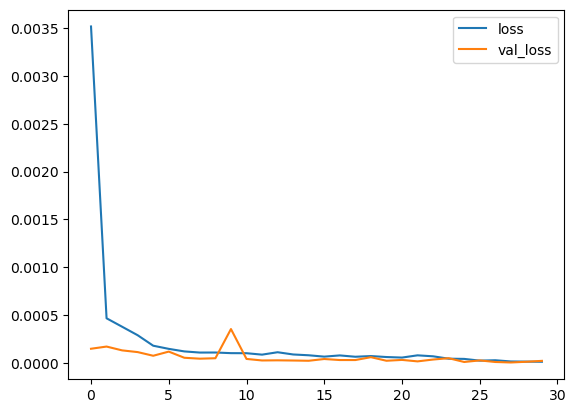

In [109]:
losses13 = pd.DataFrame(model13.history.history)
losses13.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


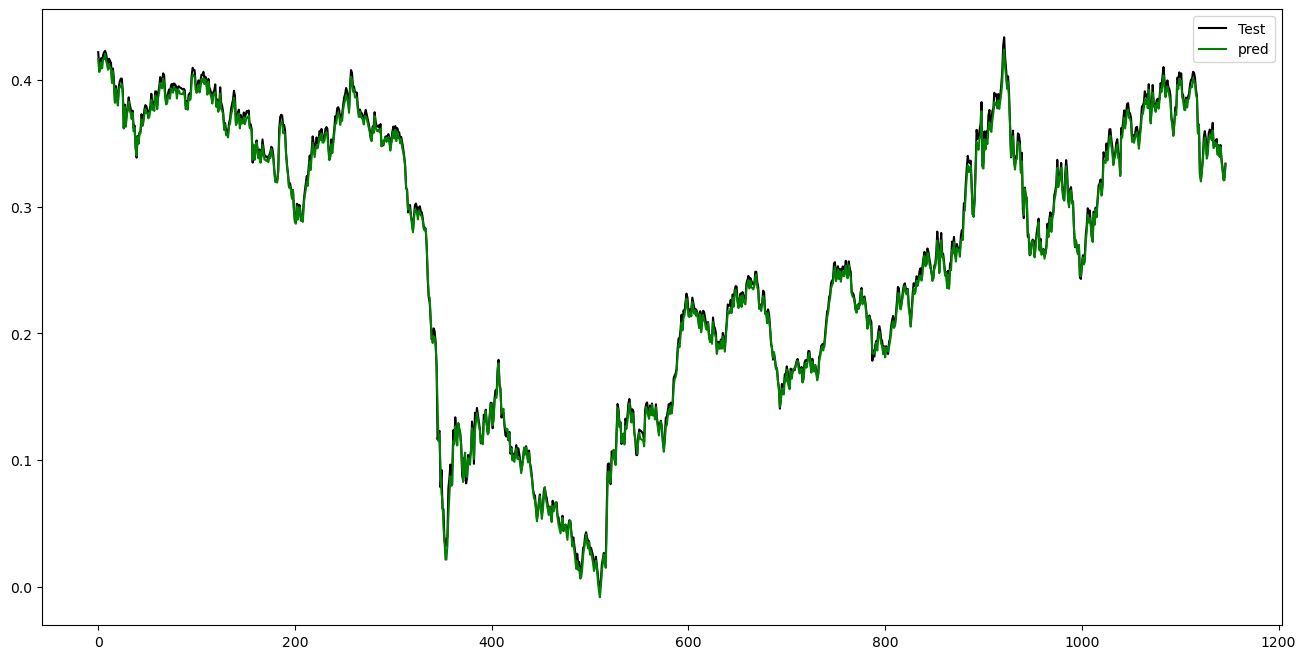

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,13,40,True,13,29,150,150,0,-0.003162,-3.626983,-0.003162,0.019816,0.0,0.004156,0.003509,inf,-9297.167672,-9231.583906,-9272.40775,4648.583836


In [110]:
modelo13=resumen(13,back,numregressors,losses13.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model13.predict(X_test),LSTM=True)
modelo13

In [111]:
#Modelo 14

neuronashidden1=150
neuronashidden2=150
neuronashidden3=50

In [112]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model14= Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model14.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 13)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           98400     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 460,208
Trainable params: 460,208
Non-trainable params: 0
_________________________________________________________________


In [113]:
%%time
model14.compile(optimizer=adam, loss='mse')
model14.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 11s 30ms/step - loss: 0.0136 - val_loss: 3.3087e-04
Epoch 2/30
276/276 [==============================] - 8s 30ms/step - loss: 8.7954e-04 - val_loss: 2.7737e-04
Epoch 3/30
276/276 [==============================] - 8s 29ms/step - loss: 6.3288e-04 - val_loss: 3.8818e-04
Epoch 4/30
276/276 [==============================] - 8s 28ms/step - loss: 4.6159e-04 - val_loss: 5.3212e-04
Epoch 5/30
276/276 [==============================] - 9s 31ms/step - loss: 3.5394e-04 - val_loss: 6.8238e-05
Epoch 6/30
276/276 [==============================] - 8s 29ms/step - loss: 2.4124e-04 - val_loss: 3.3983e-04
Epoch 7/30
276/276 [==============================] - 8s 31ms/step - loss: 2.4186e-04 - val_loss: 4.4437e-05
Epoch 8/30
276/276 [==============================] - 10s 35ms/step - loss: 1.8768e-04 - val_loss: 8.5256e-05
Epoch 9/30
276/276 [==============================] - 9s 34ms/step - loss: 1.4841e-04 - val_loss: 5.8802e-05
Epoch 10/30
276/276 [

<AxesSubplot:>

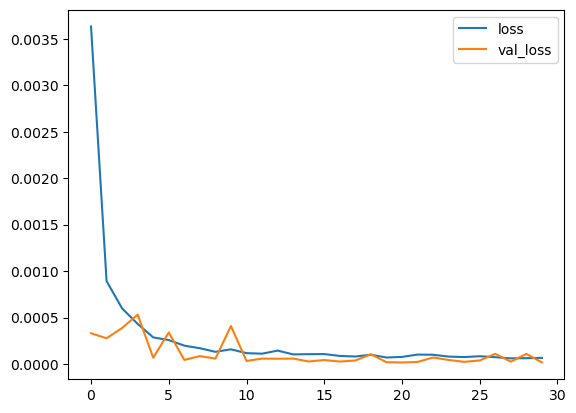

In [114]:
losses14 = pd.DataFrame(model14.history.history)
losses14.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


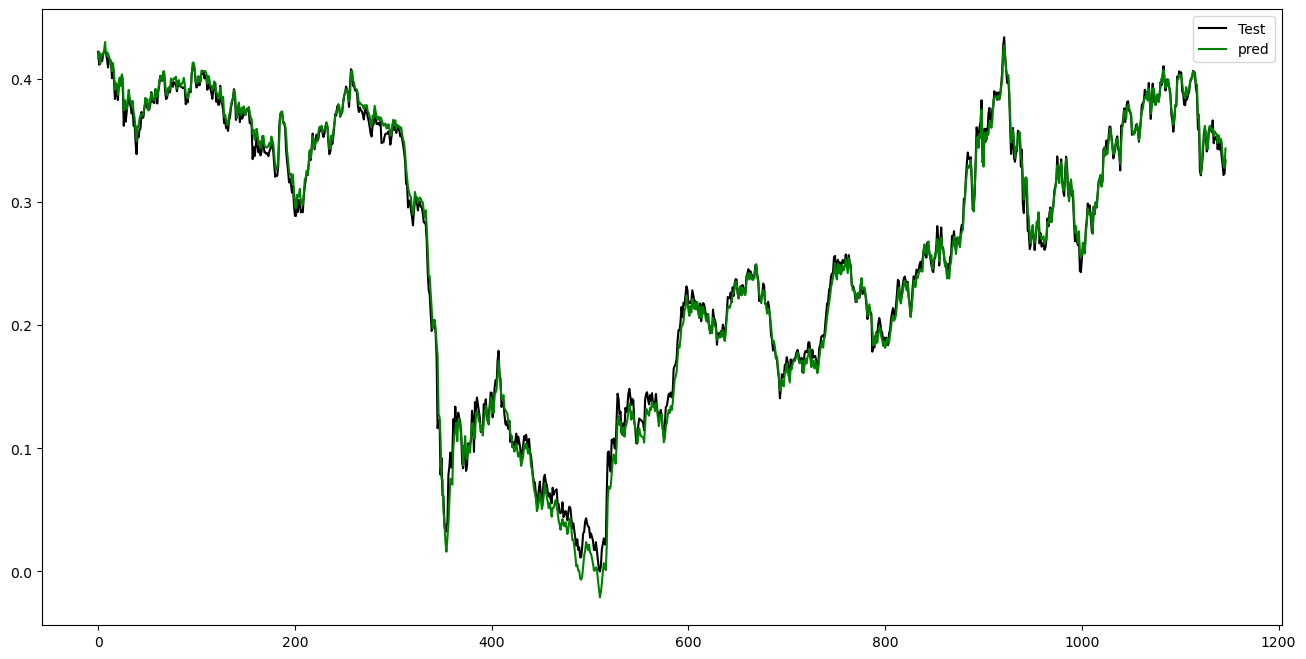

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,14,40,True,13,27,150,150,50,-0.001186,-1.360251,-0.001186,0.073244,0.0,0.007991,0.005864,inf,-7797.67528,-7732.091514,-7772.915359,3898.83764


In [115]:
modelo14=resumen(14,back,numregressors,losses14.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model14.predict(X_test),LSTM=True)
modelo14

In [116]:
#Modelo 15

neuronashidden1=150
neuronashidden2=150
neuronashidden3=150

In [117]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
hidden3= LSTM(neuronashidden2, name='Hidden3',return_sequences=True)(hidden2)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden3)
model15 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model15.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 40, 13)]          0         
_________________________________________________________________
Hidden1 (LSTM)               (None, 40, 150)           98400     
_________________________________________________________________
Hidden2 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Hidden3 (LSTM)               (None, 40, 150)           180600    
_________________________________________________________________
Output_Layer (LSTM)          (None, 1)                 608       
Total params: 460,208
Trainable params: 460,208
Non-trainable params: 0
_________________________________________________________________


In [118]:
%%time
model15.compile(optimizer=adam, loss='mse')
model15.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
276/276 [==============================] - 12s 37ms/step - loss: 0.0181 - val_loss: 2.1115e-04
Epoch 2/30
276/276 [==============================] - 9s 34ms/step - loss: 8.4040e-04 - val_loss: 2.8164e-04
Epoch 3/30
276/276 [==============================] - 9s 32ms/step - loss: 6.4612e-04 - val_loss: 3.8981e-04
Epoch 4/30
276/276 [==============================] - 10s 36ms/step - loss: 5.1654e-04 - val_loss: 2.0248e-04
Epoch 5/30
276/276 [==============================] - 10s 35ms/step - loss: 3.0328e-04 - val_loss: 6.3130e-05
Epoch 6/30
276/276 [==============================] - 10s 35ms/step - loss: 2.0899e-04 - val_loss: 3.0670e-04
Epoch 7/30
276/276 [==============================] - 10s 35ms/step - loss: 2.0090e-04 - val_loss: 8.2167e-05
Epoch 8/30
276/276 [==============================] - 10s 36ms/step - loss: 1.3282e-04 - val_loss: 5.0823e-05
Epoch 9/30
276/276 [==============================] - 10s 35ms/step - loss: 1.3855e-04 - val_loss: 5.7165e-05
Epoch 10/30
276/

<AxesSubplot:>

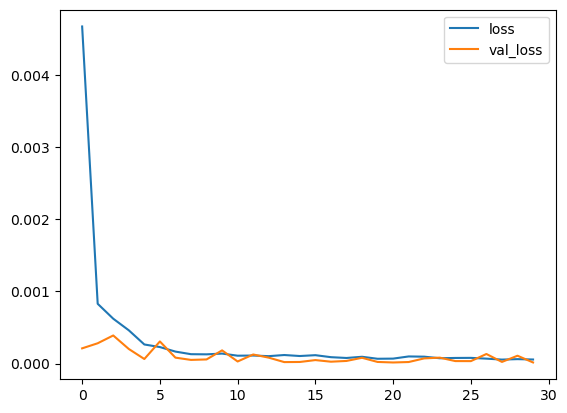

In [119]:
losses15 = pd.DataFrame(model15.history.history)
losses15.plot()

/tmp/ipykernel_42174/3014323631.py:26: RuntimeWarning: divide by zero encountered in true_divide
  mape=(100/n)*np.sum(np.abs((y_test-y_pred)/y_test))


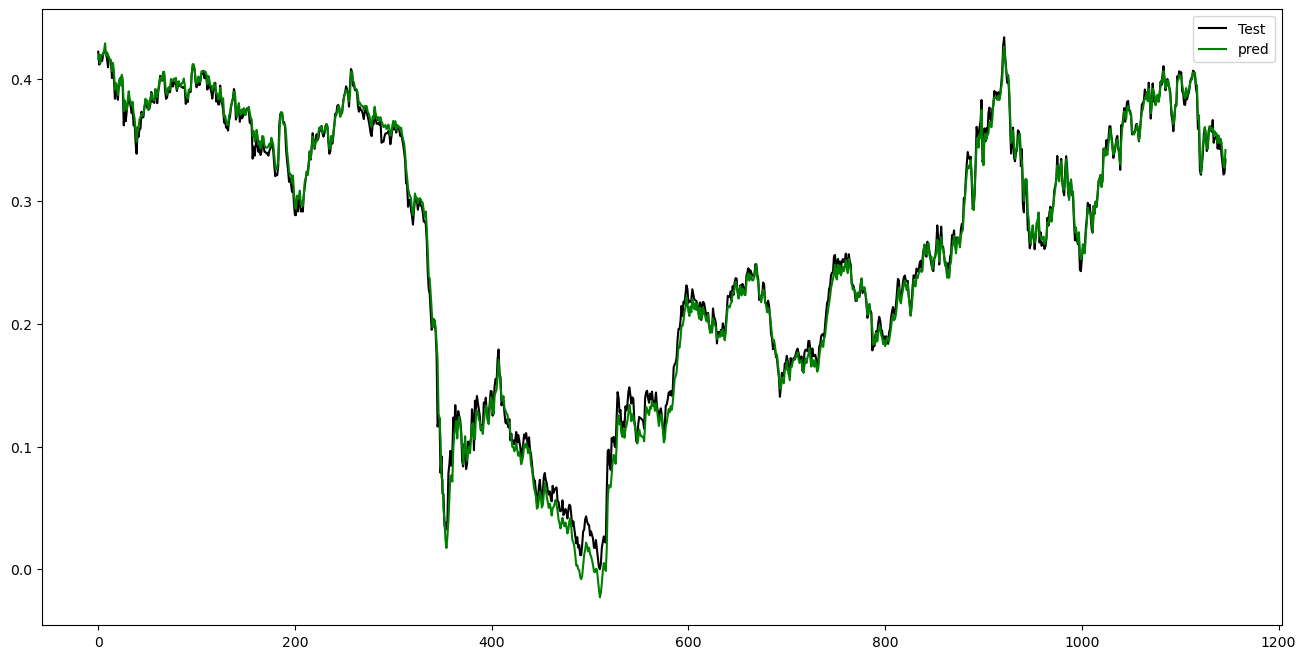

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,15,40,True,13,27,150,150,150,-0.002035,-2.334042,-0.002035,0.076824,0.0,0.008184,0.005924,inf,-7742.935912,-7677.352146,-7718.17599,3871.467956


In [120]:
modelo15=resumen(15,back,numregressors,losses15.idxmin()[0],neuronashidden1,neuronashidden2,neuronashidden3,y_test,model15.predict(X_test),LSTM=True)
modelo15

In [121]:
#Concatenar dataframes
listadf=[modelo1,modelo2,modelo3,modelo4,modelo5,modelo6,modelo7,modelo8,modelo9,modelo10,modelo10,modelo11,modelo12,modelo13,modelo14,modelo15]
dfcomparativa=pd.concat(listadf)
dfcomparativa.set_index('NumModelo')

,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
NumModelo,,,,,,,,,,,,,,,,,,,
1,40,True,4,29,150,0,0,-0.045018,-16.746725,-0.045018,3.266684,0.000000e+00,0.093709,0.061720,9.699019,-697.773804,-682.098228,-691.548607,348.886902
2,40,True,4,29,150,50,0,-0.076645,-28.512005,-0.076645,4.501501,1.110223e-16,0.110004,0.081353,12.933689,-578.497398,-562.821823,-572.272202,289.248699
3,40,True,4,20,150,150,0,-0.049215,-18.307968,-0.049215,2.494750,0.000000e+00,0.081892,0.057592,9.082846,-798.060142,-782.384566,-791.834945,399.030071
4,40,True,4,29,150,150,50,-0.172549,-64.188320,-0.172549,17.648315,6.164947e-08,0.217811,0.173413,27.611815,-70.260043,-54.584468,-64.034847,35.130022
5,40,True,4,29,150,150,150,-0.101445,-37.737595,-0.101445,7.533635,0.000000e+00,0.142308,0.104172,16.082753,-386.929739,-371.254164,-380.704543,193.464870
6,40,True,11,29,150,0,0,-0.002632,-3.018402,-0.002632,0.033090,0.000000e+00,0.005371,0.004086,inf,-8713.038876,-8657.544920,-8692.088173,4356.519438
7,40,True,11,27,150,50,0,0.000092,0.105634,0.000092,0.310181,0.000000e+00,0.016445,0.011498,inf,-6146.139081,-6090.645125,-6125.188378,3073.069541
8,40,True,11,28,150,150,0,-0.000593,-0.679604,-0.000593,0.024113,0.000000e+00,0.004585,0.003121,inf,-9076.037027,-9020.543071,-9055.086325,4538.018514
9,40,True,11,29,150,150,50,-0.004805,-5.511066,-0.004805,0.053210,0.000000e+00,0.006811,0.005734,inf,-8168.192599,-8112.698643,-8147.241896,4084.096299


In [124]:
#Menor valor de akaike

dfcomparativa[dfcomparativa['AKAIKE']==dfcomparativa['AKAIKE'].min()]

,NumModelo,Dias Muestra,LSTM,Regresores,Epochs,Capa Oculta1,Capao Oculta2,CapaOculta3,Bias,Residuo,Media Residuo,Residuo **2,P-value Jarque Bera,RMSE,MAE,MAPE,AKAIKE,BIC,HQC,DM
0,13,40,True,13,29,150,150,0,-0.003162,-3.626983,-0.003162,0.019816,0.0,0.004156,0.003509,inf,-9297.167672,-9231.583906,-9272.40775,4648.583836


In [ ]:
dfcomparativa.to_csv('ComparativaREP.csv',header=True)


## Forecast

In [139]:
data = yf.download(tickers = 'REP.MC', start = '1987-06-12',end = today)
#se vuelven a recrear los campos del modelo elegido 


data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20)
data['EMAM']=ta.ema(data.Close, length=100)
data['EMAS']=ta.ema(data.Close, length=150)

# Se crean campos personalizados para añadir las diferencias entre precio de apertura y cierre, la diferencia del dia anterior
#además de una clase binaria si la diferencia es positiva o negativa

data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)

data['Rentabilidad']=((data['Adj Close'].shift(1)-data['Adj Close'])/data['Adj Close'])*100
data['RentabilidadAcum']=np.cumsum(data['Rentabilidad'])


data.reset_index(inplace = True)
#Elimino fecha.
#Elimino cierre ajustado por ser igual en muchos casos al precio de cierre que se pretende predecir
data.drop(['Date','Adj Close'],axis=1, inplace=True)
data.dropna(inplace=True)


# Se seperan del dataframe original los datos a predecir para que no formen parte de train
hist=data[:data.shape[0]-ndias]
real=data[-ndias:]
hist.reset_index(inplace = True)
real.reset_index(inplace = True)
#Obtener de manera automatica el nuḿero de variables a evaluar 
#Todos los valores excepto el precio de cierre que es lo que se pretende predecir
#Obtener de manera automatica el nuḿero de variables a evaluar 
numregressors=data.shape[1]-1
#Por comodidad paso el precio de cierre o lo que quiero predecir  como última  columna
dataClose=data.loc[:, data.columns == 'Close']
data=data.loc[:, data.columns != 'Close']
data=pd.concat([data,dataClose],axis=1)


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- HLAG.DE: No data found for this date range, symbol may be delisted


In [136]:
#Por comodidad paso el precio de cierre o lo que quiero predecir  como última  columna

histClose=hist.loc[:, hist.columns == 'Close']
hist=hist.loc[:, hist.columns != 'Close']
hist=pd.concat([hist,histClose],axis=1)

#Aunque no lo voy a visualizar hago este paso pera evitar warning al estandarizarlos
#ya que advierte que no se pasan en el mismo orden
realClose=real.loc[:, real.columns == 'Close']
real=real.loc[:, real.columns != 'Close']
real=pd.concat([real,realClose],axis=1)

In [137]:
#debido al gran número de parámetros y la diferencia de magnitudes se estandarizan los datos para homegeneizar y obtener
#mejores resultados.
#Diferencia ahora
#Importante, estandarizo con datos de entrenamiento y lo aplico a test
#En el primer entrenamiento de la red neuronal para elección del modelo y validación se hen estandarizado todo
#los datos incluidos test
'''
La estandarización de los datos implica escalar los valores de entrada
para que tengan una media de cero y una desviación estándar de uno.
Esto ayuda a nivelar las diferencias en la escala y distribución de los datos,
lo que puede facilitar el proceso de aprendizaje de la red neuronal y mejorar su capacidad
para generalizar y hacer predicciones precisas en nuevos datos.
'''
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(hist)


ValueError: Found array with 0 sample(s) (shape=(0, 15)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:

X = []
print(data_set_scaled.shape[0])
for j in range(numregressors):
    X.append([])
    for i in range(back, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back:,-1])
y=np.reshape(yi,(len(yi),1))


In [ ]:
# Train/Test split 
splitlimit = int(len(X)*train)
print(splitlimit)
X_train, X_test = X[:splitlimit ], X[splitlimit :]
y_train, y_test = y[:splitlimit ], y[splitlimit :]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Para establecer la compartiva con ARIMA lo más fiel fijamos el numero de dias de predecir en igual longitud


In [ ]:

neuronashidden1=150
neuronashidden2=150
neuronashidden3=0

In [ ]:
lstm_input = Input(shape=(back, numregressors), name='lstm_input')

hidden1= LSTM(neuronashidden1, name='Hidden1',return_sequences=True)(lstm_input)
hidden2= LSTM(neuronashidden2, name='Hidden2',return_sequences=True)(hidden1)
output=LSTM(1,activation='linear',name ='Output_Layer')(hidden2)
model13 = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model13.summary()

In [ ]:

%%time
model13.compile(optimizer=adam, loss='mse')
model13.fit(x=X_train, y=y_train, batch_size=15, epochs=losses13.idxmin()[0], shuffle=True, validation_split = 0.1)


In [130]:
#Para la predicción standarizo los datos reales pero con los parametros de train,asi los datos a predecir
#nunca han formado parte del dataset ni siquiera para la estandarizacion
real_scaled = sc.transform(real)

In [131]:

#Vuelvo a aplicar el mismo codigo sobre los datos reales estandarizados.
#Tiene que tener la misma dimension para la predicción
X_real = []
print(real_scaled.shape[0])
for j in range(numregressors):
    X_real.append([])
    for i in range(back, real_scaled.shape[0]):
        X_real[j].append(real_scaled[i-back:i, j])


X_real=np.moveaxis(X_real, [0], [2])


X_real, yi_real =np.array(X_real), np.array(real_scaled[back:,-1])
y_real=np.reshape(yi_real,(len(yi_real),1))




1147


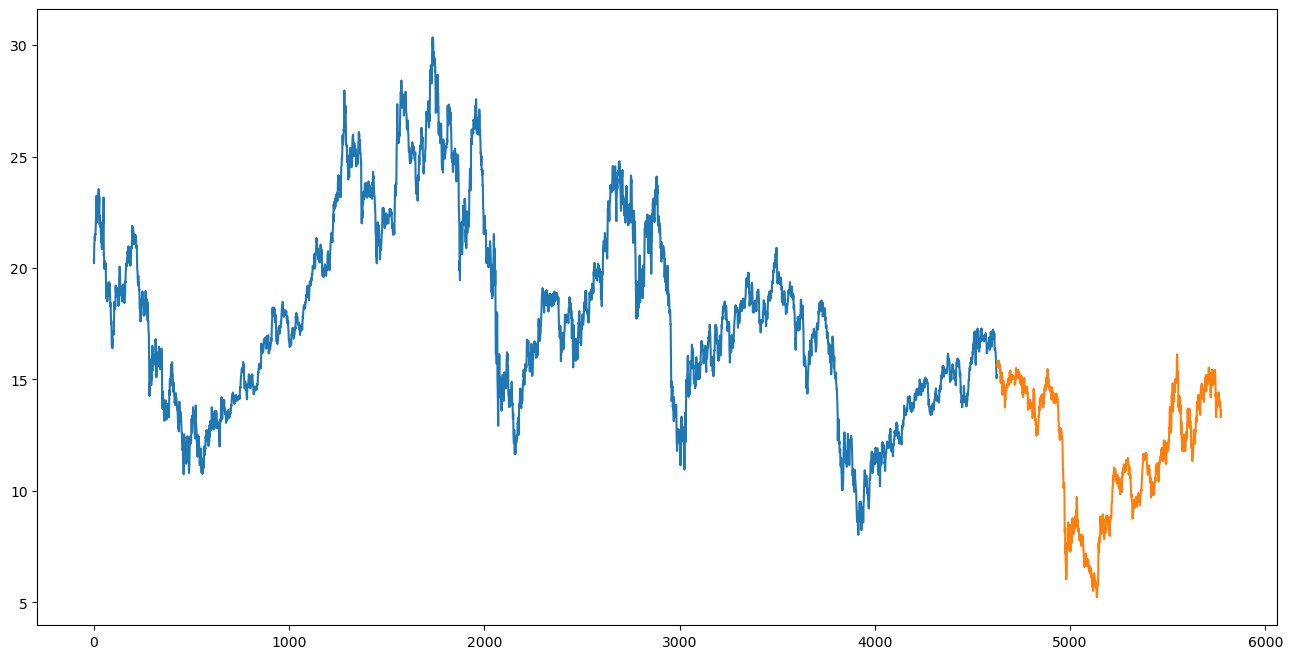

In [132]:
plt.figure(figsize=(16,8))
plt.plot(hist['Close'],label='Hist')
#Al perderse los indices modificando los dataframes añado la cotizacion real eliminada a continuación de la 
# cotizacion real
plt.plot(range(hist.shape[0],hist.shape[0]+real.shape[0]),real['Close'])

plt.show()


In [134]:
#Se predice los datos que no han formado parte del entrenamiento
forecast=model13.predict(X_real[::,::,::])
forecast=np.array(forecast)
forecast.shape

(1107, 1)

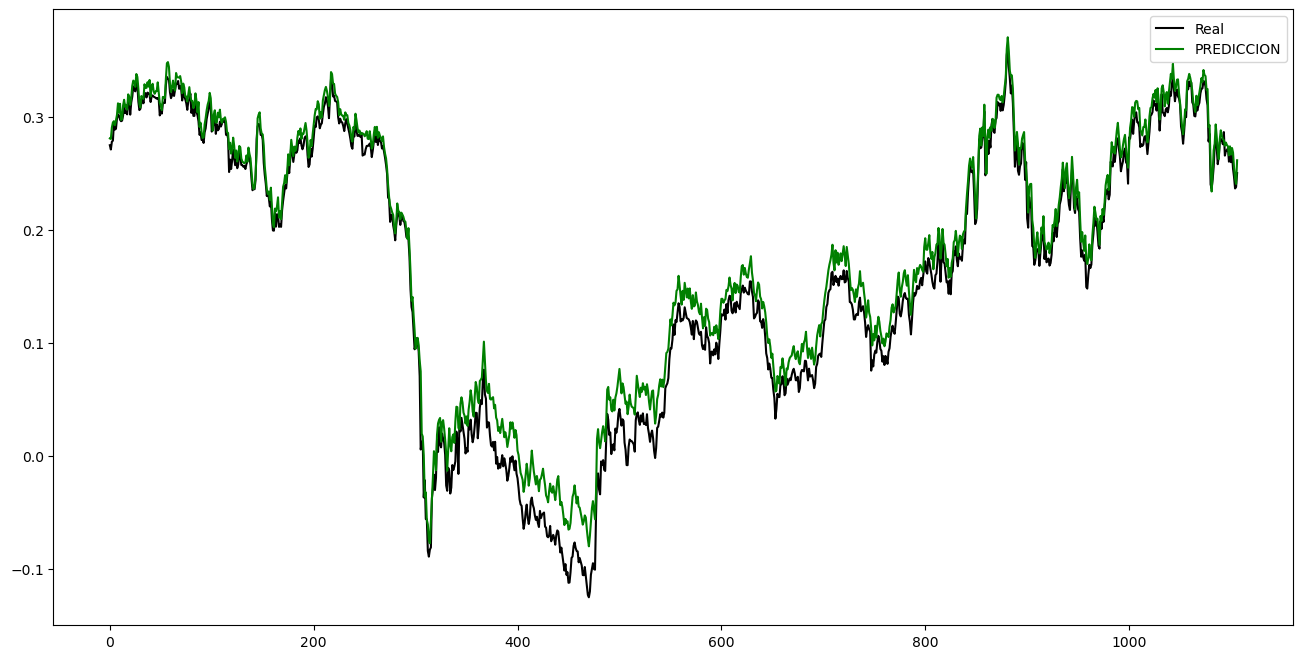

In [135]:
#en mas detalle y comparando las predicciones
plt.figure(figsize=(16,8))
plt.plot(y_real, color = 'black', label = 'Real')
#plt.plot(range(forecast.shape[0],forecast.shape[0]*2),forecast, color = 'green', label = 'pred')
plt.plot(forecast, color = 'green', label = 'PREDICCION')
plt.legend()

In [136]:
print(y_real.shape)
print(forecast.shape)

(1107, 1)
(1107, 1)


In [137]:
'''
El estadístico sigue una chi cuadrado x 2 con 2 grados de libertad y sirve para contrastar
la hipótesis nula Ho de que los residuos siguen una distribución normal Ho: los residuos
estimados se distribuyen normalmente. Si el valor estimado es mayor que el de tablas para un
determinado nivel de confianza, entonces rechazamos la hipótesis nula.
'''
def jarquebera(data,sig):
    jarqueberatest=stats.jarque_bera(data)
    if jarqueberatest[1]<sig:
        print("NO Normalidad según criterio JB")
    else:
        print("Normalidad según criterio JB")

#Para omitir Nulos o Nan en jarquebera
#jarque_bera_test = stats.jarque_bera(result.resid,nan_policy='omit')


In [138]:
def residuospredic(test,predic):

    #residuos=np.array(test_data['Close']-dfpredic['Close'])
    residuos=test-predic
#Eliminar nulos NaN
    #residuos = residuos[~np.isnan(residuos)]

    mediaresiduos=residuos.mean()
    desvresiduos=np.std(residuos)
    n=residuos.shape[0]

#Histograma
    #plt.hist(residuos,bins=50,density=True)
    plt.plot(residuos,label='residuo')
    plt.figure(figsize=(4,4))
##qqplot
    residuosv2=residuos[~np.isnan(residuos)]
    stats.probplot(residuosv2,plot=plt)

#normal
    #Dependiendo de la forma es posible tener que ajustar los limites
    #x = np.linspace(-4,4,num=n)
    x = np.linspace(-8,8,num=n)

#Caso que queramos poner como limites los valores minimo y maximo respectivamente de los residuos
#x = np.linspace(int(residuos.min()),int(residuos.max()),num=n)

#Curva normal con paramatros media= media de los residuos  y varianza= varianza de los residuos 
#En caso que los datos siguiesen dirtribucion normal se tendria que parecer a esta curva 
    y = stats.norm.pdf(x, mediaresiduos, desvresiduos)

#Curva normal N(0,1)
    y2=stats.norm.pdf(x,0,1)
    fig, ax = plt.subplots(figsize=(17,4))

# Si el residuo se distribuyese normalmente sería con esta forma N(mediaresiuos,desv residuos**2)
    ax.plot(x, y,"--", linewidth=2,c='r',label='Curva normal Teorica')
    ax.plot(x, y2,"--", linewidth=2,c='g',label='N(0,1)')
#Calculo de la funcion densidad mediante método
    #residuos.plot.kde(bw_method=0.3,label='Funcion Densidad residuos mediante kde')

#Implemantación manual de la función de densidad de los residuos
    densidadresiduos=gaussian_kde(residuosv2)
    densidadresiduos._compute_covariance()
    ax.plot(x,densidadresiduos(x),label="Residuos")

    ax.hist(x=residuos, density=True, bins=30, color="#3182bd", alpha=0.5,label='Histograma residuos')
    #ax.hist(x=residuos, density=True, bins=30,  alpha=0.5,label='Histograma residuos')
    ax.set_title('Distribución de Errores')
    ax.set_xlabel('Error')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    plt.legend()
    plt.show()
    
    #jarquebera(residuos,nivelsignificatividad)

    return jarquebera(residuos,nivelsignificatividad)

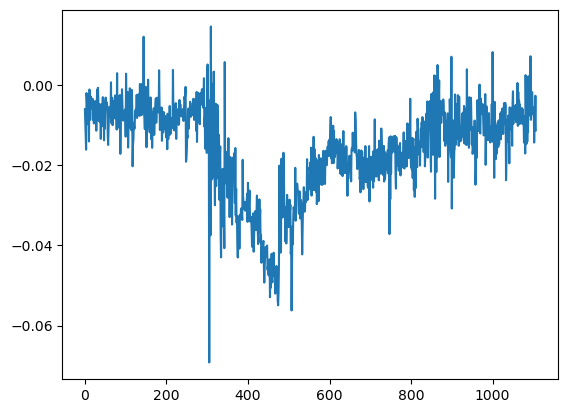

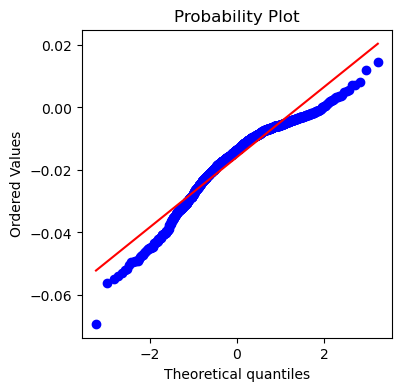

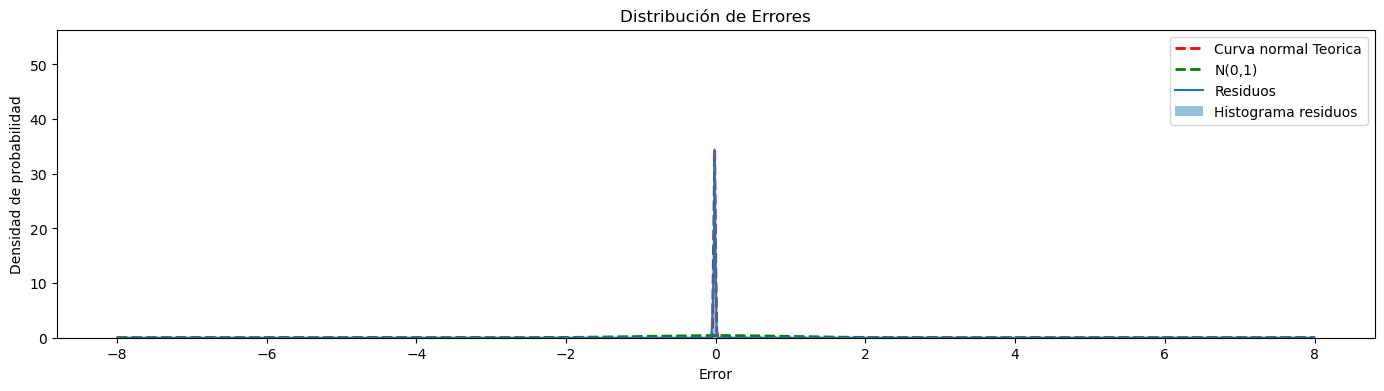

NO Normalidad según criterio JB


In [139]:
residuospredic(y_real,forecast)

In [140]:
#Tanto prediccion como datos reales se han estandarizado
#Paa deshacer la estandarizacion con el modelo creado para train necesito una matriz  de la misma dimension
#Añado ceros a la predicción para revertir la transformacion y obtener asi la cotizacion no estandarizada

In [141]:
#Para deshacer la estandarizacion los datos tienen que tener la misma dimension que antes de la transformacion
#Relleno con ceros hasta que sean de la misma dimension
aux=np.ones((forecast.shape[0],hist.shape[1]-1))
forecast=np.c_[aux,forecast]
forecastInv=sc.inverse_transform(forecast)


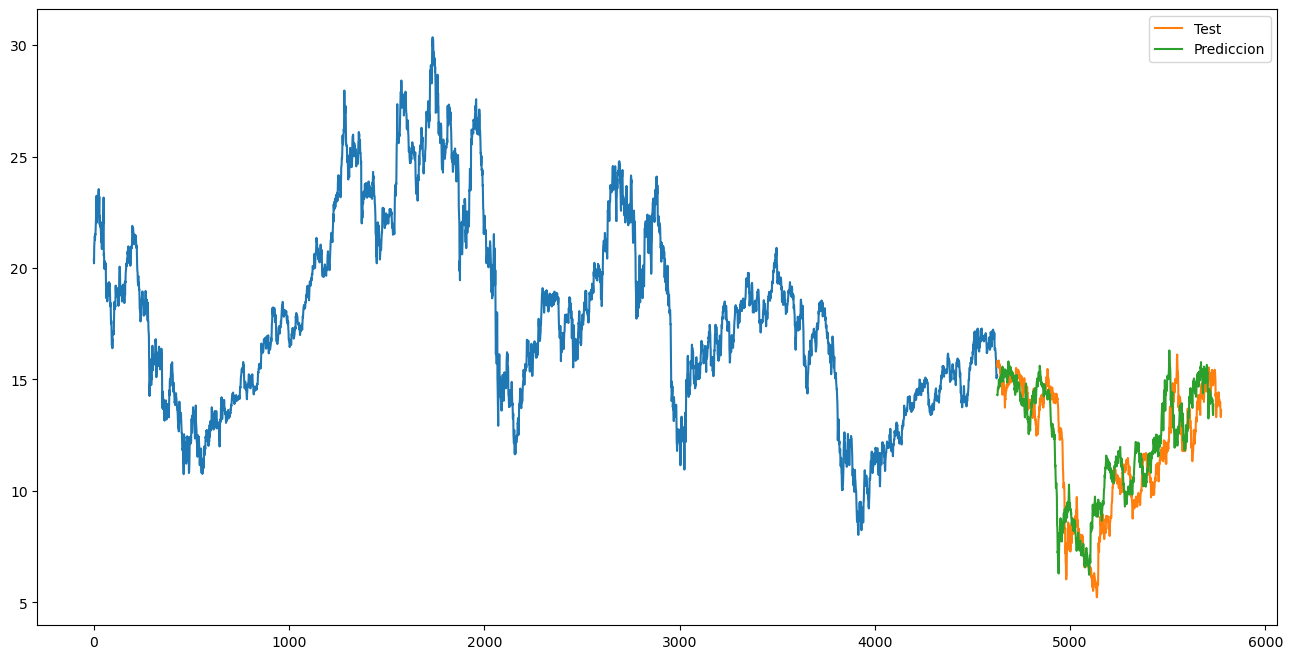

In [142]:
plt.figure(figsize=(16,8))
#plt.plot(hist['Close'],label='Hist')
#Al perderse los indices modificando los dataframes añado la cotizacion real eliminada a continuación de la 
# cotizacion real
plt.plot(hist['Close'])
plt.plot(range(hist.shape[0],hist.shape[0]+real.shape[0]),real['Close'],label='Test')
plt.plot(range(hist.shape[0],hist.shape[0]+forecastInv[::,-1].shape[0]),forecastInv[::,-1],label='Prediccion')
plt.legend()
plt.show()


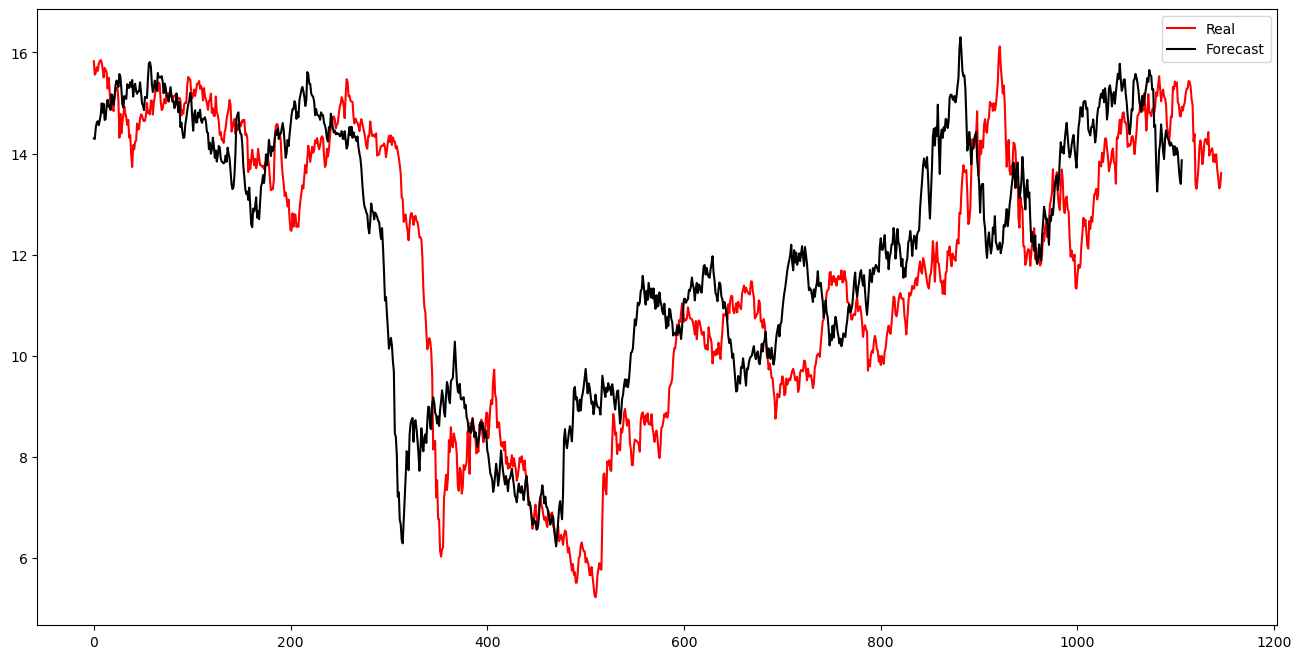

In [143]:
plt.figure(figsize=(16,8))
plt.plot(real['Close'], color = 'red', label = 'Real')

plt.plot(forecastInv[::,-1], color = 'black', label = 'Forecast')
plt.legend()

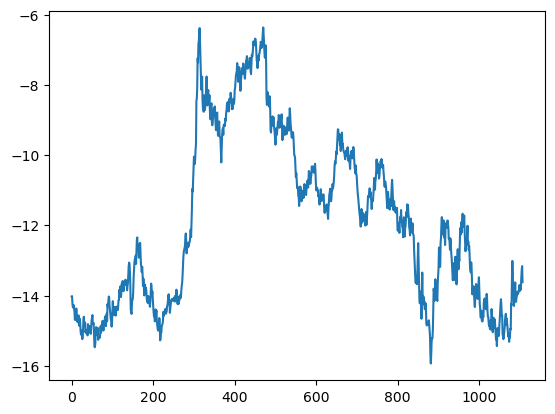

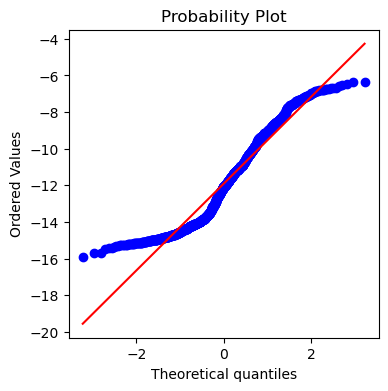

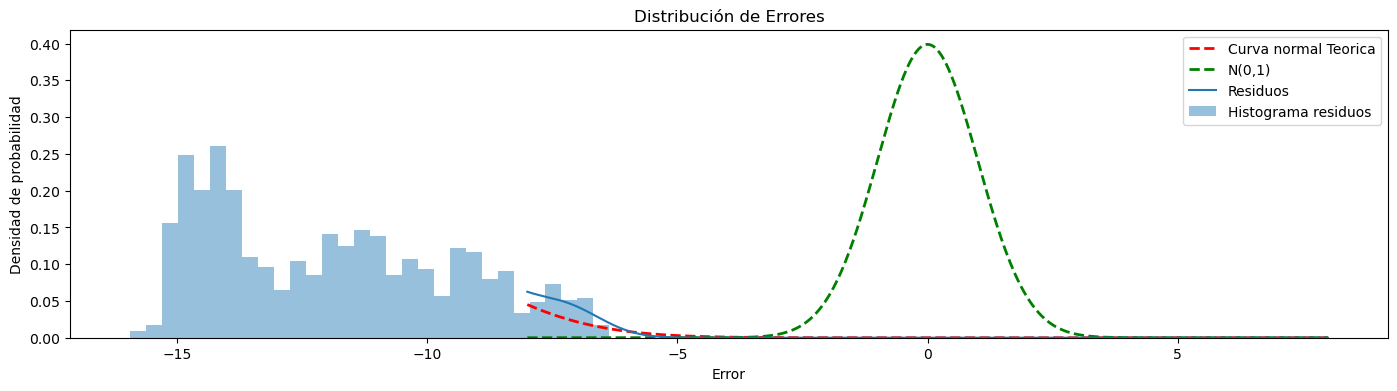

NO Normalidad según criterio JB


In [144]:
residuospredic(y_real,forecastInv[::,-1].reshape(-1,1))
#real['Close'].shape
#forecastInv[::,-1].shape


,Open,High,Low,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,Rentabilidad,RentabilidadAcum,Close
